## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card
* Bank account services
* Theft/Dispute reporting
* Mortgages/loans
* Others 


1. With the help of topic modelling, you will be able to map each ticket onto its respective department/category. 
2. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. At least any 3 models from logistic regression, naive Bayes, decision tree and random forest need to be tried and need to select the model that performs the best according to the evaluation metrics.
3. Using this trained model, you can classify any new customer complaint support ticket into its relevant department. 

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [141]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
from tqdm import tqdm
tqdm.pandas()

COLAB = True

In [142]:
import missingno as msno

SAMPLE_SIZE = 1000 #1000 # 100
SAMPLE_INDEX =  316 # 36

def percent(val, total):
    return round(100 * val/total, 2)
    
def getDFInfo(df_):
    print(f"ROWS: {df_.shape[0]}, COLUMNS: {df_.shape[1]}"); print(f"COLUMNS: {df_.columns.tolist()}")
    print(f"\nMISSING DATA: {percent(df_.isnull().sum().sum(), (df_.shape[0]*df_.shape[1]))}%")

def roundOff(value):
    #print(type(value))
    return (value/1000000).round(1)


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [143]:
# Opening JSON file 
if COLAB == True:
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
    f = open("/content/gdrive/My Drive/Colab Notebooks/complaints.json", "r")# Write the path to your data file and load it 
else:
    f = open("complaints.json", "r")# Write the path to your data file and load it 

print(f.name, type(f))
# returns JSON object as a dictionary 
data = json.load(f)
df = pd.json_normalize(data)

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/complaints.json <class '_io.TextIOWrapper'>


## Data preparation

In [144]:
# Inspect the dataframe to understand the given data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [145]:
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [146]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [147]:
df[['_source.issue', '_source.sub_issue', '_source.complaint_what_happened']].head()

,_source.issue,_source.sub_issue,_source.complaint_what_happened
0,Attempts to collect debt not owed,Debt is not yours,
1,Written notification about debt,Didn't receive enough information to verify debt,Good morning my name is XXXX XXXX and I apprec...
2,"Other features, terms, or problems",Problem with rewards from credit card,I upgraded my XXXX XXXX card in XX/XX/2018 and...
3,Trouble during payment process,None,
4,Fees or interest,Charged too much interest,


In [148]:
df['_source.issue'].head()

0     Attempts to collect debt not owed
1       Written notification about debt
2    Other features, terms, or problems
3        Trouble during payment process
4                      Fees or interest
Name: _source.issue, dtype: object

In [149]:
df[ '_source.sub_issue'].head()

0                                   Debt is not yours
1    Didn't receive enough information to verify debt
2               Problem with rewards from credit card
3                                                None
4                           Charged too much interest
Name: _source.sub_issue, dtype: object

In [150]:
df['_source.complaint_what_happened'].head()

0                                                     
1    Good morning my name is XXXX XXXX and I apprec...
2    I upgraded my XXXX XXXX card in XX/XX/2018 and...
3                                                     
4                                                     
Name: _source.complaint_what_happened, dtype: object

In [151]:
#Assign new column names
df.rename(columns = {'_index':'index', '_type':'type', '_id':'id', '_score':'score', '_source.tags':'tags', '_source.zip_code':'zip_code',
       '_source.complaint_id':'complaint_id', '_source.issue':'issue', '_source.date_received':'date_received',
       '_source.state':'state', '_source.consumer_disputed':'consumer_disputed', '_source.product':'product',
       '_source.company_response':'company_response', '_source.company':'company', '_source.submitted_via':'submitted_via',
       '_source.date_sent_to_company':'date_sent_to_company', '_source.company_public_response':'company_public_response',
       '_source.sub_product':'sub_product', '_source.timely':'timely',
       '_source.complaint_what_happened':'complaint', '_source.sub_issue':'sub_issue',
       '_source.consumer_consent_provided':'consumer_consent_provided'},inplace=True)
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


BEFORE: 57241 0 21072
AFTER: 0 57241 78313


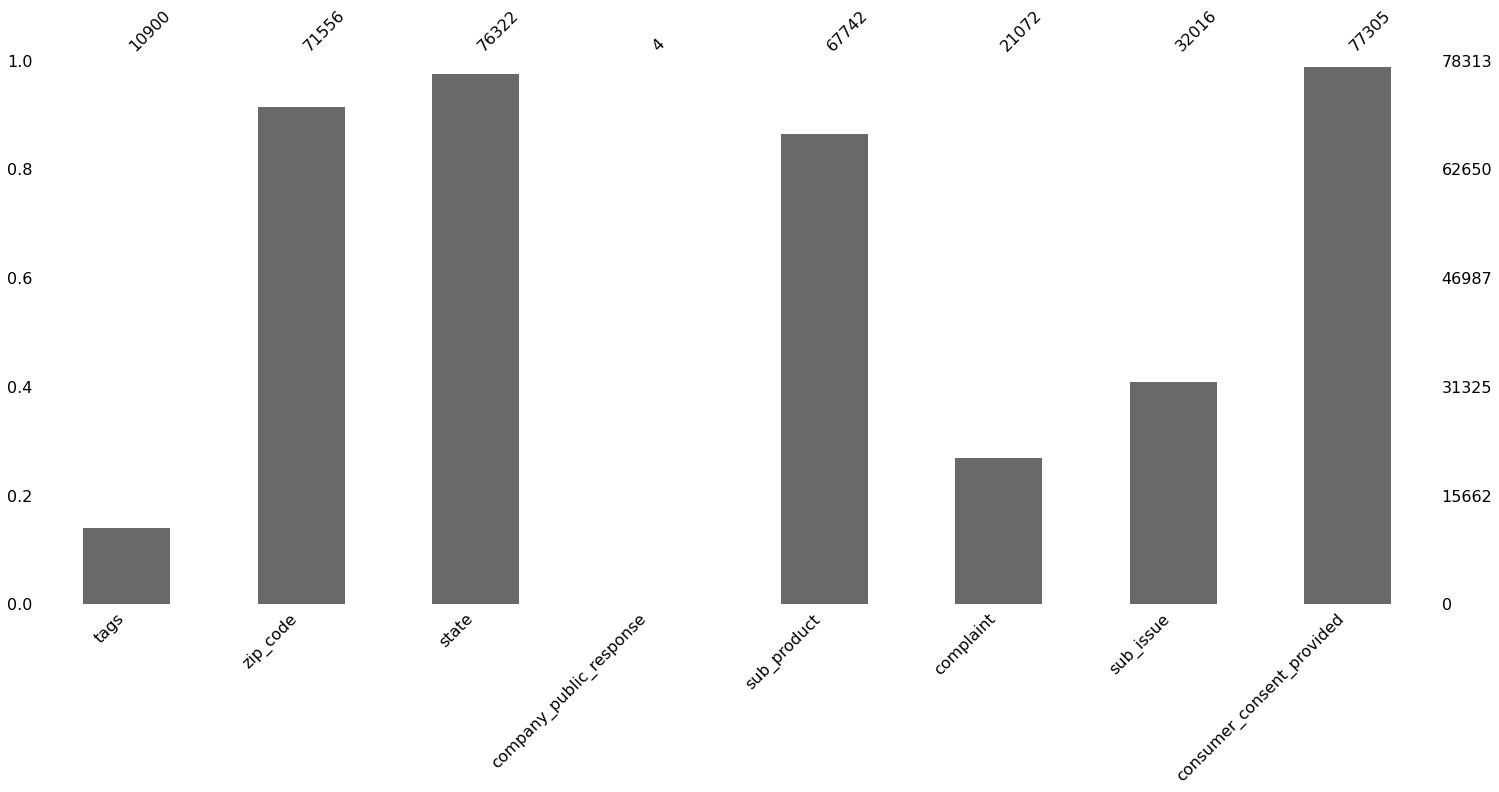

In [152]:
#Assign nan in place of blanks in the complaints column
print(f"BEFORE: {df[df['complaint']==''].shape[0]} {df[df['complaint'].isnull()]['complaint'].shape[0]} {df[~(df['complaint']=='')].shape[0]}")
df['complaint'].replace('', np.NaN, inplace=True)
print(f"AFTER: {df[df['complaint']==''].shape[0]} {df[df['complaint'].isnull()]['complaint'].shape[0]} {df[~(df['complaint']=='')].shape[0]}")
msno.bar(df[df.columns[df.isnull().any()]])

In [153]:
#Remove all rows where complaints column is nan
print(f"BEFORE: {df.shape[0]}")
df = df[~df['complaint'].isnull()]
df.reset_index(inplace=True)
print(f"AFTER: {df.shape[0]}")

BEFORE: 78313
AFTER: 21072


## TODO: SELECT ONLY A SMALL SAMPLE
To undo later

In [154]:
if COLAB == False: 
    df = df.head(1000)
    print(df.shape[0])

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


#### Make the text lowercase

In [155]:
# Make the text lowercase
print(f"BEFORE: {df['complaint'][SAMPLE_INDEX][:40]}")
df['complaint'] = df['complaint'].str.lower()
print(f"AFTER: {df['complaint'][SAMPLE_INDEX][:40]}")

BEFORE: My father in-law did my taxes and had th
AFTER: my father in-law did my taxes and had th


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Remove text in square brackets, punctuation, words containing numbers

In [156]:
# REG EXPRESSIONS
REG_TEXT_IN_SQ_BRKTS = r'\[.+?\]'
REG_PUNCT = r'[^\w\s]'
REG_WORD_WITH_NUM = r'[\w]*\d[\w]*'

In [157]:
# Test Reg expressions on a sample text
TEXT = 'Sreedevi he[ll]o!! see23y[5ou] Goodday'
re.findall(REG_TEXT_IN_SQ_BRKTS, TEXT)

['[ll]', '[5ou]']

In [158]:
# Test the reg expression on the text in the dataframe
s2 = df.loc[SAMPLE_INDEX, 'complaint']; print("Before Substitution:", len(s2), s2[0:20])
s2 = re.sub(REG_TEXT_IN_SQ_BRKTS, '', s2); print("REG_TEXT_IN_SQ_BRKTS", len(s2), s2[0:20])
s2 = re.sub(REG_PUNCT, '', s2); print("REG_PUNCT", len(s2), s2[0:20])
s2 = re.sub(REG_WORD_WITH_NUM, '', s2); print("REG_WORD_WITH_NUM", len(s2), s2[0:20]) #s2

Before Substitution: 545 my father in-law did
REG_TEXT_IN_SQ_BRKTS 545 my father in-law did
REG_PUNCT 524 my father inlaw did 
REG_WORD_WITH_NUM 512 my father inlaw did 


In [159]:
# Remove text in square brackets, punctuation, words containing numbers in the dataframe
DICT_REG = {'REG_TEXT_IN_SQ_BRKTS':REG_TEXT_IN_SQ_BRKTS, 'REG_PUNCT':REG_PUNCT, 'REG_WORD_WITH_NUM':REG_WORD_WITH_NUM}
for desc, reg in DICT_REG.items():
    df_reg = df[df['complaint'].str.contains(reg, regex=True)]['complaint']
    if df_reg.shape[0] == 0: continue
    
    print(desc, df_reg.shape[0])
    sample = df_reg.head().tolist()[0]

    print("BEFORE substitution")
    idx = df_reg.index[0]
    sample = df.loc[idx, 'complaint']
    print(idx, sample[:20])

    hits = re.findall(reg, sample)
    print(len(hits))
    [print(hit) for hit in hits]

    # Substitute
    df['complaint'] = df['complaint'].replace(reg, '', regex=True)

    print();print("AFTER substitution")
    df_reg = df[df['complaint'].str.contains(reg, regex=True)]['complaint']
    samples = df_reg.head().tolist()
    if len(samples) > 0:
        sample = samples[0]
        idx = df_reg.index[0]
        sample = df.loc[idx, 'complaint']
        print(idx, sample[:20])

        hits = re.findall(reg, sample)
        print(len(hits))
        [print(hit) for hit in hits]
    else:
        print("No hits")

    print("\n")

REG_TEXT_IN_SQ_BRKTS 206
BEFORE substitution
131 re : complaint again
12
[ t ]
[ fico scores, xxxx, xxxx and xxxx, respectively ]
[ 1427 -3272.9 ]
[ 1708 1725 ]
[ cc and her supervisor, mr. xxxx xxxx eventually, executive director, mr. xxxx xxxx ]
[ 8000 - 22980 ]
[ 11000 - 15986 ]
[ 1290012996 ]
[ 12925-12928 ]
[ 1 ]
[ which we did ]
[ 2 trusted agents of jp morgan chase ]

AFTER substitution
No hits


REG_PUNCT 20841
BEFORE substitution
0 good morning my name
7
.
.
.
.
.
#
.

AFTER substitution
No hits


REG_WORD_WITH_NUM 16493
BEFORE substitution
0 good morning my name
1
2018

AFTER substitution
No hits




In [160]:
# Check that the square brackets, punctuation, words containing numbers are not in the dataframe
df[df['complaint'].str.contains(REG_TEXT_IN_SQ_BRKTS, regex=True)]['complaint'].shape[0],               \
        df[df['complaint'].str.contains(REG_PUNCT, regex=True)]['complaint'].shape[0],                  \
            df[df['complaint'].str.contains(REG_WORD_WITH_NUM, regex=True)]['complaint'].shape[0],

(0, 0, 0)

####  Lemmatize the texts

In [161]:
# Write your function to Lemmatize the texts
### import necessary libraries
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    tokens = word_tokenize(text)
    lemmatized = [wordnet_lemmatizer.lemmatize(token) for token in tokens if not token in set(stopwords.words('english'))]
    return lemmatized

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [162]:
df['complaint'].head()

0    good morning my name is xxxx xxxx and i apprec...
1    i upgraded my xxxx xxxx card in  and was told ...
2    chase card was reported on  however fraudulent...
3    on  while trying to book a xxxx  xxxx  ticket ...
4    my grand son give me check for  i deposit it i...
Name: complaint, dtype: object

In [163]:
# test on a sample text
sample = df['complaint'].head(1).values[0]
print(sample)
' '.join(lemmatize(sample))

good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services 
in  i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt 
i have a right to know this information as a consumer 

chase account  xxxx xxxx xxxx xxxx thanks in advance for your help


'good morning name xxxx xxxx appreciate could help put stop chase bank cardmember service wrote chase asking debt verification sent statement acceptable asking bank validate debt instead receiving mail every month attempting collect debt right know information consumer chase account xxxx xxxx xxxx xxxx thanks advance help'

In [164]:
# Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame()
df_clean['complaint'] = df['complaint']
df_clean['complaint_lemma'] = df_clean['complaint'].progress_apply(lambda x: lemmatize(x))

100%|██████████| 21072/21072 [12:49<00:00, 27.40it/s]


In [165]:
df_clean.head()

,complaint,complaint_lemma
0,good morning my name is xxxx xxxx and i apprec...,"[good, morning, name, xxxx, xxxx, appreciate, ..."
1,i upgraded my xxxx xxxx card in and was told ...,"[upgraded, xxxx, xxxx, card, told, agent, upgr..."
2,chase card was reported on however fraudulent...,"[chase, card, reported, however, fraudulent, a..."
3,on while trying to book a xxxx xxxx ticket ...,"[trying, book, xxxx, xxxx, ticket, came, acros..."
4,my grand son give me check for i deposit it i...,"[grand, son, give, check, deposit, chase, acco..."


#### Use POS tags to get relevant words from the texts.

In [166]:
TRACE_IN_N_LINES = 200
def printOnceInNTimes(msg, count):
    #print(msg, count, onceIn)
    if count%TRACE_IN_N_LINES == 0: print(msg)

In [167]:
df_clean.shape

(21072, 2)

In [168]:
# Write your function to extract the POS tags 

'''
Out of all the POS tags, we 
need:           ADJ, ADV, NOUN, PROPN, VERB
do not need:    ADP, PUNCT, AUX, SYM, INTJ, CCONJ, X, DET, NUM, PART, PRON, SCONJ
'''

# RELEVANT_POS_TAGS = ['ADJ', 'ADV', 'NOUN', 'PROPN', 'VERB'] # 0
# RELEVANT_POS_TAGS = ['ADJ', 'ADV', 'NOUN', 'PROPN'] # 1
# RELEVANT_POS_TAGS = ['NOUN', 'PROPN'] # 3
RELEVANT_POS_TAGS = ['ADJ', 'ADV', 'NOUN'] # 2

# shorten the pipline loading
nlp=spacy.load('en_core_web_sm',disable=['parser','ner'])

count = 0
#for review in tqdm(df_clean['complaint_lemma'].to_list()[0:1000]):
RELEVANT_WORDS = []
POS_TAGS = {}
for index, row in tqdm(df_clean.iterrows()):
    relevant_words = []
    count += 1
    review = row['complaint_lemma']
    printOnceInNTimes(f"{count}: LEMMA: {review[:20]}", count)

    review = ' '.join(review)
    doc = nlp(review)
    for tok in doc:
        POS_TAGS[tok.pos_] = 1
        if tok.pos_ in RELEVANT_POS_TAGS: relevant_words.append(tok.lemma_)

    printOnceInNTimes(f"RELEVANT_WORDS: {relevant_words[:40]}", count)
    relevant_words = " ".join(relevant_words)
    printOnceInNTimes(f"RELEVANT_WORDS: {relevant_words[:40*10]}", count)

    RELEVANT_WORDS.append(relevant_words)
    printOnceInNTimes("", count)

print(POS_TAGS.keys())
df_clean['complaint_POS_removed'] = RELEVANT_WORDS

214it [00:02, 98.98it/s] 

200: LEMMA: ['computer', 'purchased', 'amazon', 'item', 'defective', 'returned', 'day', 'via', 'xxxx', 'tracking', 'number', 'xxxx', 'item', 'initially', 'refunded', 'well', 'credit', 'card', 'charged', 'item']
RELEVANT_WORDS: ['item', 'day', 'tracking', 'number', 'item', 'initially', 'credit', 'card', 'item', 'downhill', 'dispute', 'submit', 'information', 'return', 'item', 'response', 'favor', 'seller', 'idea', 'even', 'dispute', 'letter', 'online', 'know', 'dispute', 'recall', 'chase', 'online', 'letter', 'case', 'promptly', 'documentation', 'month', 'somehow', 'dispute', 'information', 'letter', 'chase', 'charge', 'valid']
RELEVANT_WORDS: item day tracking number item initially credit card item downhill dispute submit information return item response favor seller idea even dispute letter online know dispute recall chase online letter case promptly documentation month somehow dispute information letter chase charge valid speaking valid tracking information initial time frame initial

412it [00:03, 111.67it/s]

400: LEMMA: ['jp', 'morgan', 'chase', 'erroneously', 'charged', 'end', 'lease', 'even', 'traded', 'xxxx', 'xxxx', 'xxxx', 'xxxx', 'pull', 'ahead', 'program', 'xxxx', 'xxxx', 'dealer', 'one']
RELEVANT_WORDS: ['erroneously', 'end', 'lease', 'even', 'program', 'dealer', 'dealer', 'damage', 'opportunity', 'pre', 'inspection', 'therefore', 'transaction', 'immediately', 'statement', 'liability', 'lease', 'dispute', 'letter', 'picture', 'lease', 'deal', 'dealer', 'total', 'deal', 'advantage', 'manufacturer', 'ahead', 'program', 'monthly', 'payment', 'excess', 'wear', 'tear', 'picture', 'inclusive', 'transaction', 'shady', 'however', 'damaging']
RELEVANT_WORDS: erroneously end lease even program dealer dealer damage opportunity pre inspection therefore transaction immediately statement liability lease dispute letter picture lease deal dealer total deal advantage manufacturer ahead program monthly payment excess wear tear picture inclusive transaction shady however damaging thing credit prequal

618it [00:05, 128.31it/s]

600: LEMMA: ['greeting', 'trying', 'get', 'loan', 'modification', 'past', 'year', 'tried', 'work', 'lawyer', 'bank', 'bank', 'mailed', 'check', 'xxxx', 'returned', 'called', 'offered', 'xxxx', 'cash']
RELEVANT_WORDS: ['loan', 'modification', 'year', 'work', 'lawyer', 'check', 'cash', 'wire', 'transfer', 'hung', 'phone', 'twice', 'payout', 'taxpayer', 'business', 'thief', 'paperwork', 'court', 'several', 'year', 'hard', 'money', 'care', 'last', 'investment', 'demand', 'follow', 'law', 'home', 'loan', 'accountable', 'went', 'street', 'stole', 'purse', 'fine', 'business', 'usual', 'congressman', 'vote']
RELEVANT_WORDS: loan modification year work lawyer check cash wire transfer hung phone twice payout taxpayer business thief paperwork court several year hard money care last investment demand follow law home loan accountable went street stole purse fine business usual congressman vote american people home loan modification today time attention least agency right



813it [00:07, 137.74it/s]

800: LEMMA: ['xxxxxxxx', 'called', 'spoke', 'chase', 'auto', 'fiance', 'account', 'number', 'xxxx', 'explained', 'called', 'requested', 'billing', 'extension', 'one', 'month', 'granted', 'health', 'hospital', 'would']
RELEVANT_WORDS: ['account', 'number', 'billing', 'extension', 'month', 'health', 'hospital', 'month', 'extension', 'extension', 'however', 'due', 'date', 'month', 'also', 'payment', 'original', 'due', 'date', 'statement', 'hospital', 'back', 'agent', 'statement', 'medical', 'emergency', 'late', 'fee', 'amount', 'supervisor', 'name', 'payment', 'fee', 'original', 'due', 'date', 'month', 'supervisor', 'xxxx', 'situation']
RELEVANT_WORDS: account number billing extension month health hospital month extension extension however due date month also payment original due date statement hospital back agent statement medical emergency late fee amount supervisor name payment fee original due date month supervisor xxxx situation account current due date month circumstance credit late

1014it [00:08, 125.69it/s]

1000: LEMMA: ['long', 'story', 'short', 'currently', 'indiana', 'hardest', 'hit', 'program', 'chase', 'bank', 'put', 'illegal', 'judgement', 'investigation', 'claimed', 'defaulted', 'program', 'called', 'confirm', 'completed']
RELEVANT_WORDS: ['long', 'story', 'short', 'currently', 'hardest', 'program', 'illegal', 'judgement', 'investigation', 'program', 'dollar', 'check', 'catch', 'patent', 'take', 'catch', 'addition', 'insurance', 'policy', 'state', 'also', 'policy', 'year', 'notice', 'homeless', 'also', 'mortgage', 'document', 'illegal', 'foreclosure']
RELEVANT_WORDS: long story short currently hardest program illegal judgement investigation program dollar check catch patent take catch addition insurance policy state also policy year notice homeless also mortgage document illegal foreclosure



1210it [00:10, 122.51it/s]

1200: LEMMA: ['took', 'car', 'loan', 'chase', 'bank', 'xxxxxxxx', 'xxxx', 'paid', 'cash', 'payment', 'began', 'xxxxxxxx', 'paying', 'cash', 'time', 'lately', 'pas', 'month', 'time', 'asked']
RELEVANT_WORDS: ['car', 'cash', 'payment', 'xxxxxxxx', 'cash', 'time', 'lately', 'pas', 'month', 'time', 'cash', 'payment', 'stating', 'process', 'cash', 'replied', 'chase', 'complete', 'transaction', 'cashi', 'bill', 'last', 'month', 'account', 'replied', 'car', 'able', 'payment', 'money', 'back', 'internet', 'complaint', 'chase', 'number', 'chase', 'longer', 'cfpb', 'pay', 'bill', 'way']
RELEVANT_WORDS: car cash payment xxxxxxxx cash time lately pas month time cash payment stating process cash replied chase complete transaction cashi bill last month account replied car able payment money back internet complaint chase number chase longer cfpb pay bill way pay hassle receipt chase member equal housing lender person



1429it [00:12, 144.77it/s]

1400: LEMMA: ['writing', 'dispute', 'billing', 'error', 'amount', 'account', 'merchant', 'xxxx', 'closed', 'error', 'due', 'incompetence', 'dispute', 'billing', 'staff', 'prescription', 'lens', 'received', 'damaged', 'replacement']
RELEVANT_WORDS: ['dispute', 'billing', 'error', 'amount', 'account', 'merchant', 'closed', 'error', 'due', 'incompetence', 'dispute', 'staff', 'prescription', 'lens', 'replacement', 'continually', 'rude', 'representative', 'statement', 'dispute', 'vision', 'check', 'incorrectly', 'prematurely', 'disupte', 'lens', 'cracked', 'need']
RELEVANT_WORDS: dispute billing error amount account merchant closed error due incompetence dispute staff prescription lens replacement continually rude representative statement dispute vision check incorrectly prematurely disupte lens cracked need



1623it [00:13, 138.99it/s]

1600: LEMMA: ['may', 'concern', 'vacation', 'xxxx', 'looked', 'account', 'online', 'chase', 'bank', 'noticed', 'credit', 'card', 'purchase', 'never', 'made', 'xxxx', 'called', 'chase', 'right', 'away']
RELEVANT_WORDS: ['concern', 'vacation', 'account', 'credit', 'card', 'purchase', 'never', 'right', 'away', 'customer', 'service', 'card', 'new', 'card', 'back', 'charge', 'back', 'account', 'explanation', 'able', 'customer', 'service', 'department', 'available', 'number', 'available', 'talk', 'claim', 'police', 'claim', 'purchase', 'place', 'credit', 'address', 'number', 'call', 'ever', 'chase', 'time', 'letter']
RELEVANT_WORDS: concern vacation account credit card purchase never right away customer service card new card back charge back account explanation able customer service department available number available talk claim police claim purchase place credit address number call ever chase time letter close fraud case help victim fraud bank chase help reason reason comment letter charg

1818it [00:14, 150.74it/s]

1800: LEMMA: ['xxxxxxxx', 'husband', 'went', 'chase', 'branch', 'open', 'joint', 'account', 'woman', 'helped', 'u', 'problem', 'opening', 'account', 'deposited', 'two', 'check', 'new', 'account', 'total']
RELEVANT_WORDS: ['branch', 'joint', 'account', 'woman', 'problem', 'account', 'new', 'account', 'total', 'account', 'yet', 'notice', 'account', 'closed', 'reason', 'access', 'countless', 'time', 'incredibly', 'check', 'account', 'closed', 'money', 'back', 'day', 'family', 'chase', 'incredibly', 'money', 'back']
RELEVANT_WORDS: branch joint account woman problem account new account total account yet notice account closed reason access countless time incredibly check account closed money back day family chase incredibly money back



2028it [00:16, 134.64it/s]

2000: LEMMA: ['chase', 'bank', 'locked', 'account', 'due', 'suspicious', 'activity', 'tried', 'pay', 'lawyer', 'xxxx', 'xxxx', 'pay', 'sent', 'code', 'text', 'entered', 'initially', 'accepted', 'emailed']
RELEVANT_WORDS: ['account', 'due', 'suspicious', 'activity', 'pay', 'lawyer', 'code', 'text', 'initially', 'account', 'message', 'instructing', 'payment', 'valid', 'payment', 'account', 'instructing', 'call', 'hour', 'hold', 'matter', 'success', 'account', 'bank', 'chase', 'history', 'people', 'reddit', 'thread', 'ability', 'open', 'new', 'account', 'fund', 'bank', 'other', 'money', 'access', 'money', 'chase']
RELEVANT_WORDS: account due suspicious activity pay lawyer code text initially account message instructing payment valid payment account instructing call hour hold matter success account bank chase history people reddit thread ability open new account fund bank other money access money chase account unavailable fix situation change policy procedure financial incentive accuracy m

2213it [00:17, 137.64it/s]

2200: LEMMA: ['opened', 'account', 'chase', 'bonus', 'advertised', 'never', 'received', 'bonus', 'called', 'third', 'time', 'follow', 'yesterday', 'last', 'day', 'receive', 'bonus', 'customer', 'service', 'representative']
RELEVANT_WORDS: ['account', 'bonus', 'never', 'bonus', 'third', 'time', 'yesterday', 'last', 'day', 'bonus', 'customer', 'service', 'representative', 'around', 'time', 'patient', 'first', 'time', 'direct', 'deposit', 'requirement', 'bonus']
RELEVANT_WORDS: account bonus never bonus third time yesterday last day bonus customer service representative around time patient first time direct deposit requirement bonus



2416it [00:19, 127.84it/s]

2400: LEMMA: ['tried', 'opening', 'account', 'chase', 'bank', 'around', 'xxxx', 'last', 'year', 'denied', 'returned', 'deposit', 'back', 'given', 'proper', 'reason', 'denied', 'account', 'beginning', 'covid']
RELEVANT_WORDS: ['account', 'last', 'year', 'deposit', 'back', 'proper', 'reason', 'account', 'covid', 'pandemic', 'bother', 'bank', 'opend', 'account', 'problem', 'new', 'business', 'yesterday', 'partner', 'open', 'business', 'account', 'multiple', 'account', 'able', 'open', 'account', 'signer', 'account', 'business', 'account', 'able', 'operate', 'account', 'able', 'write', 'check', 'sign', 'check', 'reason']
RELEVANT_WORDS: account last year deposit back proper reason account covid pandemic bother bank opend account problem new business yesterday partner open business account multiple account able open account signer account business account able operate account able write check sign check reason least basis denial legal right action thank



2622it [00:20, 135.29it/s]

2600: LEMMA: ['business', 'account', 'large', 'bank', 'outfit', 'year', 'time', 'daily', 'deposit', 'bank', 'matrix', 'siphoned', 'per', 'year', 'annually', 'average', 'un', 'stoppable', 'spiraling', 'effect']
RELEVANT_WORDS: ['business', 'large', 'bank', 'outfit', 'year', 'year', 'annually', 'average', 'spiraling', 'effect', 'matter', 'many', 'balloon', 'payment', 'always', 'situation', 'glitch', 'effort', 'business', 'expense', 'much', 'never', 'excessive', 'charge', 'also', 'numerous', 'late', 'fee', 'area', 'business', 'due', 'stress', 'cash', 'flow', 'help', 'expense', 'cash', 'little', 'debt', 'today']
RELEVANT_WORDS: business large bank outfit year year annually average spiraling effect matter many balloon payment always situation glitch effort business expense much never excessive charge also numerous late fee area business due stress cash flow help expense cash little debt today system daily deposit transaction statement review forward request



2813it [00:22, 132.99it/s]

2800: LEMMA: ['chase', 'offer', 'xxxx', 'credit', 'card', 'advertising', 'additional', 'reward', 'spend', 'xxxx', 'hotel', 'v', 'spend', 'late', 'xxxx', 'xxxx', 'announced', 'partnership', 'xxxx', 'xxxx']
RELEVANT_WORDS: ['credit', 'card', 'additional', 'reward', 'v', 'spend', 'late', 'credit', 'card', 'term', 'property', 'eligible', 'additional', 'reward', 'email', 'directly', 'advertising', 'subject', 'cardmember', 'destination', 'body', 'even', 'credit', 'cardmember', 'point', 'eligible', 'location', 'term', 'current', 'credit', 'card', 'page', 'creditcardschasecomtravelcreditcardsworldofhyattcreditcard', 'bonus', 'point', 'point', 'usd', 'purchase', 'hotel', 'resort']
RELEVANT_WORDS: credit card additional reward v spend late credit card term property eligible additional reward email directly advertising subject cardmember destination body even credit cardmember point eligible location term current credit card page creditcardschasecomtravelcreditcardsworldofhyattcreditcard bonus po

3021it [00:23, 143.07it/s]

3000: LEMMA: ['chase', 'failed', 'disclose', 'would', 'additional', 'lien', 'title', 'paying', 'extended', 'amount', 'payment', 'time', 'span', 'xxxx', 'xxxx', 'xxxx', 'paid', 'month', 'year', 'stii']
RELEVANT_WORDS: ['additional', 'title', 'extended', 'amount', 'payment', 'time', 'span', 'month', 'year', 'stii', 'additional', 'clear', 'title', 'information', 'house', 'predatory', 'behavior']
RELEVANT_WORDS: additional title extended amount payment time span month year stii additional clear title information house predatory behavior



3223it [00:25, 137.39it/s]

3200: LEMMA: ['identity', 'stolen', 'several', 'account', 'opened', 'fraudulently', 'name', 'checking', 'account', 'compromised', 'money', 'taken', 'ive', 'close', 'open', 'new', 'bank', 'account', 'ive', 'requested']
RELEVANT_WORDS: ['identity', 'several', 'account', 'fraudulently', 'name', 'account', 'money', 'close', 'open', 'new', 'bank', 'account', 'account', 'credit', 'report', 'unable', 'request', 'example', 'account', 'credit', 'report', 'example', 'credit', 'reporting', 'agency', 'creditor', 'state', 'information', 'credit', 'reporting', 'agency', 'creditor', 'information', 'account', 'several', 'time', 'credit', 'reporting', 'agency', 'actual']
RELEVANT_WORDS: identity several account fraudulently name account money close open new bank account account credit report unable request example account credit report example credit reporting agency creditor state information credit reporting agency creditor information account several time credit reporting agency actual data verify a

3419it [00:26, 131.87it/s]

3400: LEMMA: ['xxxxxxxx', 'xxxx', 'xxxx', 'wife', 'xxxx', 'xxxx', 'xxxx', 'decided', 'inquire', 'putting', 'residence', 'located', 'xxxx', 'xxxx', 'xxxx', 'xxxx', 'xxxx', 'az', 'xxxx', 'sale']
RELEVANT_WORDS: ['wife', 'inquire', 'residence', 'sale', 'process', 'title', 'company', 'authorization', 'process', 'son', 'subordinate', 'trust', 'amount', 'home', 'loan', 'modification', 'daughter', 'law', 'full', 'authorization', 'discus', 'modification', 'end', 'amount', 'close', 'representative', 'branch', 'modification', 'package', 'branch', 'speak', 'manager', 'branch', 'manager', 'situation', 'identity', 'term', 'mortgage', 'customer', 'service']
RELEVANT_WORDS: wife inquire residence sale process title company authorization process son subordinate trust amount home loan modification daughter law full authorization discus modification end amount close representative branch modification package branch speak manager branch manager situation identity term mortgage customer service number una

3621it [00:28, 136.12it/s]

3600: LEMMA: ['chase', 'bank', 'breach', 'contract', 'including', 'part', 'evidence', 'document', 'chase', 'bank', 'continues', 'refer', 'prior', 'withdrawal', 'try', 'coverup', 'xxxxxxxx', 'chase', 'branch', 'xxxx']
RELEVANT_WORDS: ['contract', 'part', 'evidence', 'prior', 'withdrawal', 'try', 'coverup', 'approximately', 'withdrawal', 'branch', 'teller', 'head', 'teller', 'able', 'money', 'likely', 'due', 'complaint', 'chase', 'bank', 'practice', 'prior', 'tremendous', 'pain', 'able', 'withdraw', 'cash', 'bank', 'ample', 'time', 'contract', 'even', 'phone', 'state', 'different', 'date', 'withdrawal']
RELEVANT_WORDS: contract part evidence prior withdrawal try coverup approximately withdrawal branch teller head teller able money likely due complaint chase bank practice prior tremendous pain able withdraw cash bank ample time contract even phone state different date withdrawal



3817it [00:29, 127.76it/s]

3800: LEMMA: ['xxxxxxxx', 'made', 'payment', 'effective', 'date', 'xxxxxxxx', 'payment', 'made', 'chase', 'credit', 'card', 'ending', 'xxxx', 'payment', 'subsequently', 'honored', 'xxxx', 'xxxx', 'debited', 'checking']
RELEVANT_WORDS: ['payment', 'effective', 'date', 'payment', 'chase', 'credit', 'card', 'payment', 'subsequently', 'account', 'use', 'card', 'small', 'balance', 'approximately', 'due', 'recent', 'purchase', 'make', 'purchase', 'payment', 'authorization', 'repeatedly', 'chase', 'investigation', 'chase', 'payment', 'use', 'time', 'notice', 'credit', 'limit', 'instead', 'daughter', 'law', 'payment', 'account', 'chase', 'payment', 'confirmation']
RELEVANT_WORDS: payment effective date payment chase credit card payment subsequently account use card small balance approximately due recent purchase make purchase payment authorization repeatedly chase investigation chase payment use time notice credit limit instead daughter law payment account chase payment confirmation email cred

4010it [00:31, 122.50it/s]

4000: LEMMA: ['set', 'business', 'credit', 'card', 'account', 'chase', 'ink', 'xxxx', 'set', 'account', 'automatic', 'payment', 'bank', 'account', 'reason', 'automatic', 'payment', 'rejected', 'unfortunately', 'xxxx']
RELEVANT_WORDS: ['business', 'credit', 'card', 'account', 'account', 'account', 'reason', 'automatic', 'payment', 'unfortunately', 'payment', 'never', 'total', 'month', 'fine', 'immediately', 'dollar', 'completely', 'account', 'chase', 'business', 'account', 'delinquent', 'also', 'personal', 'credit', 'card', 'much', 'chase', 'company', 'customer', 'service', 'folk', 'helpful', 'willing', 'reinstate', 'credit', 'card', 'guidance', 'prevent']
RELEVANT_WORDS: business credit card account account account reason automatic payment unfortunately payment never total month fine immediately dollar completely account chase business account delinquent also personal credit card much chase company customer service folk helpful willing reinstate credit card guidance prevent impact cred

4225it [00:32, 128.45it/s]

4200: LEMMA: ['hi', 'name', 'xxxx', 'xxxx', 'customer', 'chase', 'bank', 'past', 'nine', 'yearsmy', 'checking', 'number', 'xxxx', 'last', 'xxxxxxxx', 'pay', 'check', 'stolen', 'car', 'however']
RELEVANT_WORDS: ['name', 'customer', 'yearsmy', 'number', 'last', 'xxxxxxxx', 'pay', 'check', 'car', 'however', 'remote', 'deposit', 'option', 'cellphone', 'concerned', 'pay', 'check', 'discussion', 'check', 'number', 'maker', 'period', 'former', 'employer', 'check', 'deposit', 'remote', 'option', 'xxxx', 'cellphone', 'month', 'official', 'pay', 'check', 'branch', 'customer', 'repeatedly', 'never', 'use', 'party']
RELEVANT_WORDS: name customer yearsmy number last xxxxxxxx pay check car however remote deposit option cellphone concerned pay check discussion check number maker period former employer check deposit remote option xxxx cellphone month official pay check branch customer repeatedly never use party submit pay check ear bank manager customer care helpline use scenario loyal customer year p

4418it [00:34, 144.69it/s]

4400: LEMMA: ['refinanced', 'mortgage', 'jp', 'morgan', 'chase', 'bank', 'late', 'try', 'take', 'advantage', 'lower', 'interest', 'rate', 'lower', 'monthly', 'payment', 'amount', 'chase', 'holder', 'mortgage']
RELEVANT_WORDS: ['mortgage', 'late', 'advantage', 'low', 'interest', 'rate', 'low', 'monthly', 'payment', 'amount', 'chase', 'holder', 'mortgage', 'time', 'process', 'hopefully', 'miscue', 'process', 'repeatedly', 'repayment', 'term', 'accurate', 'time', 'originally', 'mortgage', 'payment', 'chase', 'dramatically', 'year', 'purchase', 'escrow', 'account', 'year', 'later', 'clear', 'want', 'history', 'repeat', 'first', 'mortgage']
RELEVANT_WORDS: mortgage late advantage low interest rate low monthly payment amount chase holder mortgage time process hopefully miscue process repeatedly repayment term accurate time originally mortgage payment chase dramatically year purchase escrow account year later clear want history repeat first mortgage broker supervisor request final mortgage pa

4615it [00:35, 126.80it/s]

4600: LEMMA: ['chase', 'bank', 'refusing', 'take', 'responsibility', 'late', 'payment', 'reported', 'credit', 'report', 'result', 'phone', 'agent', 'setting', 'payment', 'incorrectly', 'request', 'enrollment', 'hardship', 'program']
RELEVANT_WORDS: ['responsibility', 'late', 'payment', 'credit', 'report', 'result', 'phone', 'agent', 'payment', 'incorrectly', 'enrollment', 'hardship', 'program', 'different', 'account', 'hardship', 'program', 'correctly', 'correctly', 'however', 'third', 'account', 'automatic', 'transfer', 'date', 'rolling', 'late', 'payment', 'report', 'credit', 'report', 'payment', 'due', 'date', 'chase', 'already', 'day', 'due', 'incorrect', 'phone']
RELEVANT_WORDS: responsibility late payment credit report result phone agent payment incorrectly enrollment hardship program different account hardship program correctly correctly however third account automatic transfer date rolling late payment report credit report payment due date chase already day due incorrect phone 

4817it [00:37, 115.35it/s]

4800: LEMMA: ['ordered', 'rug', 'website', 'xxxx', 'order', 'number', 'xxxx', 'amount', 'xxxx', 'linked', 'debit', 'card', 'fraud', 'issue', 'order', 'email', 'confirming', 'order', 'number', 'xxxx']
RELEVANT_WORDS: ['rug', 'website', 'order', 'number', 'amount', 'debit', 'card', 'fraud', 'issue', 'order', 'email', 'order', 'number', 'duplicate', 'order', 'order', 'number', 'amount', 'debit', 'card', 'account', 'transaction', 'sure', 'transaction', 'order', 'number', 'account', 'immediately', 'website', 'request', 'duplicate', 'order', 'xxxx', 'order', 'issue', 'refund', 'place', 'order', 'response', 'date']
RELEVANT_WORDS: rug website order number amount debit card fraud issue order email order number duplicate order order number amount debit card account transaction sure transaction order number account immediately website request duplicate order xxxx order issue refund place order response date time important request support staff additional comment reply email order different rug a

5017it [00:38, 139.99it/s]

5000: LEMMA: ['hello', 'deposited', 'xxxx', 'xxxx', 'xxxx', 'check', 'chase', 'xxxx', 'amount', 'xxxx', 'xxxx', 'xxxx', 'account', 'chase', 'account', 'check', 'got', 'cleared', 'xxxx', 'money']
RELEVANT_WORDS: ['account', 'check', 'money', 'copy', 'check', 'transaction', 'mail', 'chase', 'deposit', 'name', 'account', 'longer', 'active', 'need', 'work', 'figure', 'money', 'bank', 'branch', 'address', 'check', 'account', 'apparently', 'automatically', 'due', 'inactivity', 'never', 'check', 'brach', 'money', 'information', 'chase', 'money', 'basically', 'bank', 'povide', 'detail', 'name', 'account']
RELEVANT_WORDS: account check money copy check transaction mail chase deposit name account longer active need work figure money bank branch address check account apparently automatically due inactivity never check brach money information chase money basically bank povide detail name account



5216it [00:40, 138.63it/s]

5200: LEMMA: ['creditor', 'chase', 'bank', 'usa', 'na', 'credit', 'bureau', 'xxxx', 'xxxxxxxx', 'request', 'removal', 'unauthorized', 'inquiry', 'dear', 'sir', 'madam', 'checked', 'personal', 'credit', 'report']
RELEVANT_WORDS: ['dear', 'personal', 'credit', 'report', 'unauthorized', 'inquiry', 'several', 'occasion', 'inquiry', 'credit', 'inquiry', 'credit', 'profile', 'due', 'identify', 'theft', 'xxxxxxxx', 'yet', 'investigation', 'report', 'immediately', 'legal', 'time', 'inquiry', 'result', 'investigation', 'signature', 'valid', 'proof', 'person', 'inquiry', 'unauthorized', 'inquiry', 'copy', 'credit', 'report', 'address', 'inquiry', 'valid', 'description']
RELEVANT_WORDS: dear personal credit report unauthorized inquiry several occasion inquiry credit inquiry credit profile due identify theft xxxxxxxx yet investigation report immediately legal time inquiry result investigation signature valid proof person inquiry unauthorized inquiry copy credit report address inquiry valid descrip

5414it [00:41, 115.18it/s]

5400: LEMMA: ['chase', 'bank', 'located', 'xxxx', 'xxxx', 'ca', 'xxxx', 'put', 'paycheck', 'xxxx', 'atm', 'machine', 'machine', 'ate', 'check', 'never', 'putting', 'account', 'giving', 'receipt']
RELEVANT_WORDS: ['machine', 'machine', 'check', 'never', 'account', 'receipt', 'machine', 'unable', 'retrieve', 'check', 'immediately', 'informed', 'manager', 'claim', 'next', 'month', 'half', 'numerous', 'fee', 'lie', 'phone', 'claim', 'incompetent', 'many', 'hour', 'work', 'resolve', 'issue', 'claim', 'claim', 'brand', 'new', 'cellphone', 'refund', 'back', 'today', 'week', 'xxxxxxxx', 'paycheck', 'initial']
RELEVANT_WORDS: machine machine check never account receipt machine unable retrieve check immediately informed manager claim next month half numerous fee lie phone claim incompetent many hour work resolve issue claim claim brand new cellphone refund back today week xxxxxxxx paycheck initial claim money account numerous fee unhappy customer service fee everyday refuse close account month l

5618it [00:43, 139.41it/s]

5600: LEMMA: ['usually', 'big', 'fan', 'chase', 'messed', 'credit', 'card', 'account', 'really', 'frustrated', 'upset', 'hoping', 'help', 'sent', 'replacement', 'card', 'without', 'consent', 'tried', 'call']
RELEVANT_WORDS: ['usually', 'big', 'fan', 'chase', 'credit', 'card', 'account', 'really', 'upset', 'help', 'replacement', 'card', 'consent', 'call', 'fix', 'issue', 'company', 'fix', 'enough', 'sorry', 'information', 'safe', 'behalf', 'prior', 'consent']
RELEVANT_WORDS: usually big fan chase credit card account really upset help replacement card consent call fix issue company fix enough sorry information safe behalf prior consent



5826it [00:44, 134.45it/s]

5800: LEMMA: ['inquiry', 'removed']
RELEVANT_WORDS: []
RELEVANT_WORDS: 



6018it [00:46, 135.74it/s]

6000: LEMMA: ['hired', 'xxxx', 'xxxx', 'xxxx', 'contact', 'jpmorganchase', 'behalf', 'short', 'sale', 'home', 'xxxx', 'xxxx', 'attorney', 'notified', 'chase', 'wanted', 'another', 'appraisal', 'due', 'last']
RELEVANT_WORDS: ['sale', 'attorney', 'chase', 'appraisal', 'due', 'last', 'strange', 'xxxx', 'people', 'home', 'last', 'appraiser', 'document', 'customer', 'service', 'document', 'phone', 'appraisal', 'attorney', 'call', 'chase', 'purchase', 'price', 'document', 'attorney', 'buyer', 'okay', 'next', 'thing', 'short', 'sale', 'attorney', 'short', 'sale', 'due', 'arrearage', 'home', 'totally', 'month', 'ago']
RELEVANT_WORDS: sale attorney chase appraisal due last strange xxxx people home last appraiser document customer service document phone appraisal attorney call chase purchase price document attorney buyer okay next thing short sale attorney short sale due arrearage home totally month ago anyway letter compensate finding error document collection period application mortgage assist

6220it [00:47, 128.11it/s]

6200: LEMMA: ['write', 'letter', 'past', 'month', 'month', 'went', 'back', 'forth', 'chase', 'fraud', 'dispute', 'department', 'regarding', 'two', 'unauthorized', 'transaction', 'credit', 'card', 'totaling', 'amount']
RELEVANT_WORDS: ['letter', 'month', 'month', 'back', 'forth', 'fraud', 'unauthorized', 'transaction', 'credit', 'card', 'totaling', 'amount', 'transaction', 'card', 'replacement', 'thought', 'fraud', 'however', 'charge', 'dispute', 'previously', 'business', 'transaction', 'amount', 'transaction', 'amount', 'charge', 'consumer', 'service', 'address', 'charge', 'previously', 'contractor', 'charge', 'however', 'credit', 'card', 'balance', 'dramatic', 'noticed']
RELEVANT_WORDS: letter month month back forth fraud unauthorized transaction credit card totaling amount transaction card replacement thought fraud however charge dispute previously business transaction amount transaction amount charge consumer service address charge previously contractor charge however credit card ba

6427it [00:49, 138.79it/s]

6400: LEMMA: ['shocked', 'reviewing', 'credit', 'report', 'found', 'late', 'payment', 'date', 'day', 'late', 'xxxxxxxx', 'day', 'late', 'xxxxxxxx', 'sure', 'happened', 'believe', 'made', 'payment', 'received']
RELEVANT_WORDS: ['credit', 'report', 'late', 'payment', 'date', 'late', 'late', 'sure', 'payment', 'statement', 'statement']
RELEVANT_WORDS: credit report late payment date late late sure payment statement statement



6626it [00:50, 135.65it/s]

6600: LEMMA: ['chase', 'united', 'airline', 'prominently', 'display', 'advertisement', 'incentive', 'purchased', 'united', 'airline', 'ticket', 'understanding', 'statement', 'credit', 'would', 'posted', 'united', 'explorer', 'credit', 'account']
RELEVANT_WORDS: ['prominently', 'ticket', 'statement', 'credit', 'however', 'conveniently', 'purchase', 'credit', 'card', 'application', 'session', 'therefore', 'eligible', 'credit', 'much', 'session', 'online', 'application', 'alert', 'condition', 'secure', 'credit', 'fine', 'print', 'hassle', 'credit', 'card']
RELEVANT_WORDS: prominently ticket statement credit however conveniently purchase credit card application session therefore eligible credit much session online application alert condition secure credit fine print hassle credit card



6825it [00:52, 136.90it/s]

6800: LEMMA: ['credit', 'limit', 'lowered', 'without', 'knowledge', 'received', 'information', 'going', 'happen', 'called', 'company', 'stated', 'letter', 'sent', 'receive', 'process', 'moving', 'found', 'decrease', 'xxxx']
RELEVANT_WORDS: ['credit', 'limit', 'knowledge', 'information', 'company', 'letter', 'receive', 'process', 'decrease', 'due', 'credit', 'report', 'limited', 'low', 'utilization', 'letter', 'information', 'fully', 'credit', 'card', 'month', 'use', 'card', 'month', 'original', 'credit', 'card', 'line', 'credit', 'pull', 'multiple', 'time', 'definition', 'low', 'spending', 'limited', 'utilization', 'low', 'credit', 'limit']
RELEVANT_WORDS: credit limit knowledge information company letter receive process decrease due credit report limited low utilization letter information fully credit card month use card month original credit card line credit pull multiple time definition low spending limited utilization low credit limit prevent future right low credit limit able tell

7020it [00:53, 141.55it/s]

7000: LEMMA: ['chase', 'visa', 'failed', 'investigate', 'many', 'identified', 'unauthorized', 'charge', 'failed', 'reported', 'miss', 'timeline', 'eligible', 'file', 'chargeback', 'visa', 'strangely', 'credit', 'putting', 'others']
RELEVANT_WORDS: ['many', 'unauthorized', 'charge', 'timeline', 'eligible', 'file', 'strangely', 'credit', 'other', 'even', 'vendor', 'valid', 'merchant', 'obligation', 'documentation', 'support', 'charge', 'patenly', 'false', 'never', 'sale', 'draft', 'unauthorized', 'activity']
RELEVANT_WORDS: many unauthorized charge timeline eligible file strangely credit other even vendor valid merchant obligation documentation support charge patenly false never sale draft unauthorized activity



7219it [00:55, 141.65it/s]

7200: LEMMA: ['chase', 'bank', 'closed', 'personal', 'credit', 'card', 'personal', 'checking', 'personal', 'saving', 'account', 'closed', 'business', 'checking', 'business', 'credit', 'card', 'blue', 'closed', 'everything']
RELEVANT_WORDS: ['personal', 'credit', 'card', 'personal', 'personal', 'saving', 'account', 'business', 'business', 'credit', 'card', 'never', 'late', 'payment', 'time', 'great', 'client', 'year', 'several', 'hour', 'several', 'different', 'employee', 'person', 'hour', 'today', 'branch', 'manager', 'senior', 'phone', 'account', 'detail', 'transaction', 'year', 'account', 'state', 'chase', 'terminate', 'relationship', 'decision']
RELEVANT_WORDS: personal credit card personal personal saving account business business credit card never late payment time great client year several hour several different employee person hour today branch manager senior phone account detail transaction year account state chase terminate relationship decision irrevocable never account chase

7413it [00:56, 137.56it/s]

7400: LEMMA: ['chase', 'recently', 'mailed', 'notice', 'regarding', 'change', 'card', 'member', 'agreement', 'stated', 'account', 'holder', 'subject', 'binding', 'arbitration', 'unless', 'written', 'optout', 'letter', 'sent']
RELEVANT_WORDS: ['recently', 'notice', 'change', 'card', 'member', 'agreement', 'account', 'subject', 'arbitration', 'letter', 'also', 'language', 'regard', 'force', 'active', 'duty', 'military', 'consumer', 'arbitration', 'however', 'credit', 'card', 'account', 'date', 'chase', 'compliance', 'therefore', 'subject', 'change', 'arbitration', 'read', 'state', 'consumer', 'borrower', 'consumer', 'active', 'duty', 'consumer', 'obligated', 'consumer']
RELEVANT_WORDS: recently notice change card member agreement account subject arbitration letter also language regard force active duty military consumer arbitration however credit card account date chase compliance therefore subject change arbitration read state consumer borrower consumer active duty consumer obligated co

7621it [00:58, 149.65it/s]

7600: LEMMA: ['xxxx', 'xxxx', 'local', 'chase', 'branch', 'xxxx', 'colorado', 'closed', 'checking', 'saving', 'account', 'without', 'warning', 'denied', 'withdrawal', 'request', 'atm', 'branch', 'immediately', 'went']
RELEVANT_WORDS: ['local', 'branch', 'saving', 'account', 'withdrawal', 'branch', 'immediately', 'branch', 'restriction', 'fund', 'available', 'want', 'business', 'longer', 'letter', 'account', 'information', 'information', 'request', 'chase', 'branch', 'rest', 'money', 'statement', 'also', 'letter', 'chase', 'fraud', 'fraud', 'acct', 'cover', 'loss', 'question', 'call', 'message', 'return', 'letter', 'right', 'money', 'close']
RELEVANT_WORDS: local branch saving account withdrawal branch immediately branch restriction fund available want business longer letter account information information request chase branch rest money statement also letter chase fraud fraud acct cover loss question call message return letter right money close ccount senior usual call innocent wrong c

7813it [00:59, 132.16it/s]

7800: LEMMA: ['xxxx', 'xxxx', 'chase', 'bank', 'xxxx', 'tx', 'told', 'durable', 'poa', 'bring', 'unsigned', 'check', 'bank', 'deposit', 'violation', 'never', 'accepted', 'unendorsed', 'check', 'multitude']
RELEVANT_WORDS: ['durable', 'poa', 'unsigned', 'check', 'bank', 'deposit', 'violation', 'never', 'unendorsed', 'check', 'still', 'amount', 'period', 'law', 'old', 'xxxx', 'fund']
RELEVANT_WORDS: durable poa unsigned check bank deposit violation never unendorsed check still amount period law old xxxx fund



8014it [01:01, 136.06it/s]

8000: LEMMA: ['signed', 'chase', 'xxxx', 'xxxx', 'credit', 'card', 'promised', 'free', 'night', 'first', 'year', 'anniversary', 'hotel', 'category', 'point', 'limit', 'ever', 'yesterday', 'received', 'letter']
RELEVANT_WORDS: ['credit', 'card', 'free', 'night', 'first', 'year', 'anniversary', 'hotel', 'category', 'point', 'limit', 'ever', 'yesterday', 'letter', 'notify', 'free', 'reward', 'night', 'point', 'value', 'opinion', 'chasexxxxxxxx', 'illegal', 'bait', 'switch', 'marketing', 'advertise', 'customer', 'change', 'rule', 'current', 'costumer', 'grandfather', 'promotion', 'actual', 'customer', 'already', 'card', 'introductory', 'offer']
RELEVANT_WORDS: credit card free night first year anniversary hotel category point limit ever yesterday letter notify free reward night point value opinion chasexxxxxxxx illegal bait switch marketing advertise customer change rule current costumer grandfather promotion actual customer already card introductory offer time case right time enrollment



8220it [01:02, 135.11it/s]

8200: LEMMA: ['filed', 'complaint', 'chase', 'refused', 'admit', 'xxxx', 'modify', 'legal', 'since', 'document', 'prove', 'xxxxxxxx', 'denied', 'modify', 'right', 'move', 'alone', 'extend', 'start', 'loan']
RELEVANT_WORDS: ['legal', 'document', 'modify', 'right', 'move', 'alone', 'loan', 'approval', 'xxxxxxxx', 'witness', 'suppose', 'letter', 'proof', 'victim', 'preditory', 'want', 'start', 'loan', 'profit', 'principle', 'top', 'long', 'asset', 'never', 'copy', 'modify', 'sign', 'even', 'chase', 'claim', 'phone', 'xxxxxxxx', 'letter', 'never', 'bottom', 'letter', 'pay', 'cause', 'default', 'month']
RELEVANT_WORDS: legal document modify right move alone loan approval xxxxxxxx witness suppose letter proof victim preditory want start loan profit principle top long asset never copy modify sign even chase claim phone xxxxxxxx letter never bottom letter pay cause default month appraisal forbearance still regular payment modification trial period witness default fraud



8420it [01:04, 132.70it/s]

8400: LEMMA: ['trying', 'close', 'account', 'held', 'jointly', 'deceased', 'parent', 'father', 'died', 'xxxx', 'mother', 'died', 'xxxxxxxx', 'sole', 'heir', 'listed', 'legally', 'personal', 'representative', 'last']
RELEVANT_WORDS: ['close', 'account', 'jointly', 'deceased', 'parent', 'father', 'mother', 'sole', 'heir', 'legally', 'personal', 'representative', 'last', 'trouble', 'response', 'chase', 'numerous', 'phone', 'call', 'finally', 'able', 'address', 'information', 'information', 'xxxx', 'able', 'branch', 'documentation', 'receipt', 'letter', 'able', 'chase', 'documentation', 'piece', 'additional', 'documentation', 'small', 'estate', 'document', 'today']
RELEVANT_WORDS: close account jointly deceased parent father mother sole heir legally personal representative last trouble response chase numerous phone call finally able address information information xxxx able branch documentation receipt letter able chase documentation piece additional documentation small estate document tod

8620it [01:05, 142.27it/s]

8600: LEMMA: ['chase', 'closed', 'account', 'number', 'xxxx', 'xxxx', 'xxxx', 'xxxx', 'good', 'reason', 'chase', 'closed', 'account', 'around', 'unrecognized', 'charge', 'reported']
RELEVANT_WORDS: ['account', 'number', 'good', 'reason', 'account', 'unrecognized', 'charge']
RELEVANT_WORDS: account number good reason account unrecognized charge



8815it [01:07, 122.26it/s]

8800: LEMMA: ['xxxxxxxx', 'consumer', 'financial', 'protection', 'bureau', 'xxxx', 'xxxx', 'xxxx', 'xxxx', 'ia', 'xxxx', 'subject', 'request', 'help', 'victim', 'retaliation', 'chase', 'bank', 'filing', 'complaint']
RELEVANT_WORDS: ['consumer', 'subject', 'request', 'help', 'victim', 'filing', 'cfpb', 'complaint', 'constant', 'persistent', 'threat', 'covid', 'patient', 'symptomatic', 'pandemic', 'chase', 'employee', 'chase', 'unable', 'good', 'measure', 'online', 'credit', 'card', 'balance', 'interestlate', 'fee', 'chase', 'direct', 'result', 'hack', 'security', 'breach', 'chase', 'acct', 'payment', 'chase', 'credit', 'card', 'account']
RELEVANT_WORDS: consumer subject request help victim filing cfpb complaint constant persistent threat covid patient symptomatic pandemic chase employee chase unable good measure online credit card balance interestlate fee chase direct result hack security breach chase acct payment chase credit card account active credit card active online account chase 

9022it [01:08, 152.61it/s]

9000: LEMMA: ['writing', 'delete', 'following', 'information', 'file', 'item', 'need', 'deleted', 'listed', 'report', 'victim', 'identity', 'theft', 'make', 'charge', 'ask', 'item', 'deleted', 'correct', 'credit']
RELEVANT_WORDS: ['delete', 'information', 'file', 'item', 'report', 'victim', 'identity', 'theft', 'charge', 'item', 'correct', 'credit', 'report', 'theft', 'identity', 'also', 'copy', 'identity', 'theft', 'delete', 'item', 'soon', 'possible']
RELEVANT_WORDS: delete information file item report victim identity theft charge item correct credit report theft identity also copy identity theft delete item soon possible



9220it [01:10, 114.10it/s]

9200: LEMMA: ['chase', 'xxxx', 'xxxx', 'xxxx', 'pmt', 'xxxx', 'conspired', 'manfactured', 'evidence', 'chase', 'cashed', 'regular', 'pmt', 'xxxx', 'request', 'pmt', 'xxxx', 'month', 'xxxx', 'falisfied']
RELEVANT_WORDS: ['manfactured', 'evidence', 'chase', 'regular', 'pmt', 'month', 'property', 'tax', 'insurance', 'evidence', 'pmts', 'also', 'receipt', 'account', 'chase', 'speeding', 'foreclosure', 'proper', 'merit', 'cause', 'fraudulent', 'evidence', 'escrow', 'account', 'accounting', 'foreclose', 'illegal', 'immoral', 'acti', 'loan', 'lawyer', 'property', 'regular', 'payment', 'xxxx', 'payment', 'ofxxxxxxxx', 'xxxx', 'instruction', 'payment']
RELEVANT_WORDS: manfactured evidence chase regular pmt month property tax insurance evidence pmts also receipt account chase speeding foreclosure proper merit cause fraudulent evidence escrow account accounting foreclose illegal immoral acti loan lawyer property regular payment xxxx payment ofxxxxxxxx xxxx instruction payment need pay xxxx instea

9412it [01:11, 135.77it/s]

9400: LEMMA: ['credit', 'monitoring', 'serif', 'xxxx', 'xxxx', 'received', 'notification', 'hard', 'inquiry', 'following', 'financial', 'institution', 'xxxx', 'xxxx', 'xxxx', 'xxxx', 'xxxx', 'xxxx', 'xxxx', 'oh']
RELEVANT_WORDS: ['credit', 'notification', 'hard', 'inquiry', 'financial', 'institution', 'finance', 'document', 'view', 'credit', 'history']
RELEVANT_WORDS: credit notification hard inquiry financial institution finance document view credit history



9622it [01:13, 134.56it/s]

9600: LEMMA: ['purchase', 'year', 'service', 'contract', 'merchant', 'xxxxxxxx', 'contract', 'end', 'xxxxxxxx', 'merchant', 'lock', 'account', 'disable', 'get', 'access', 'service', 'purchased', 'submitted', 'evidence', 'chase']
RELEVANT_WORDS: ['purchase', 'year', 'service', 'contract', 'merchant', 'xxxxxxxx', 'contract', 'merchant', 'lock', 'account', 'disable', 'access', 'service', 'evidence', 'chase', 'ignore', 'evidence', 'explanation', 'feedback', 'dispute', 'case', 'communication']
RELEVANT_WORDS: purchase year service contract merchant xxxxxxxx contract merchant lock account disable access service evidence chase ignore evidence explanation feedback dispute case communication



9823it [01:14, 129.94it/s]

9800: LEMMA: ['husband', 'laid', 'filed', 'bankruptcy', 'became', 'two', 'month', 'behind', 'mortgage', 'chase', 'home', 'finance', 'loan', 'modification', 'offered', 'instead', 'put', 'repayment', 'plan', 'charged']
RELEVANT_WORDS: ['bankruptcy', 'month', 'mortgage', 'finance', 'loan', 'modification', 'instead', 'repayment', 'plan', 'exorbitant', 'fee', 'month', 'overcharged']
RELEVANT_WORDS: bankruptcy month mortgage finance loan modification instead repayment plan exorbitant fee month overcharged



10016it [01:15, 152.87it/s]

10000: LEMMA: ['regard', 'complaint', 'xxxx', 'person', 'bearing', 'account', 'question', 'letter', 'dated', 'chase', 'addressed', 'person', 'never', 'tie', 'account', 'whatsoever', 'apparently', 'attempt', 'chase', 'delay']
RELEVANT_WORDS: ['regard', 'complaint', 'person', 'question', 'letter', 'person', 'never', 'account', 'whatsoever', 'apparently', 'delay', 'complaint']
RELEVANT_WORDS: regard complaint person question letter person never account whatsoever apparently delay complaint



10214it [01:17, 141.35it/s]

10200: LEMMA: ['used', 'credit', 'card', 'car', 'service', 'xxxx', 'fraudulent', 'charge', 'made', 'account', 'credit', 'card', 'company', 'called', 'closed', 'card', 'new', 'one', 'sent', 'card']
RELEVANT_WORDS: ['credit', 'card', 'car', 'service', 'xxxx', 'fraudulent', 'charge', 'account', 'credit', 'card', 'company', 'closed', 'card', 'card', 'however', 'somehow', 'charge', 'even', 'closed', 'card', 'statement', 'card', 'somehow', 'fraudulently', 'card', 'statement', 'day', 'card', 'large', 'long', 'ride', 'understand', 'company', 'card', 'fraud', 'company', 'closing', 'card', 'card', 'information']
RELEVANT_WORDS: credit card car service xxxx fraudulent charge account credit card company closed card card however somehow charge even closed card statement card somehow fraudulently card statement day card large long ride understand company card fraud company closing card card information fraudulently card time contact extremely slow stop account essentially powerless continued fraud m

10417it [01:18, 131.51it/s]

10400: LEMMA: ['chase', 'bank', 'refused', 'honor', 'promissory', 'note', 'financial', 'asset', 'yet', 'kept', 'beyond', 'midnight', 'deadline', 'asset', 'connected', 'ucc', 'xxxx', 'seen', 'cash', 'xxxx']
RELEVANT_WORDS: ['honor', 'promissory', 'note', 'financial', 'asset', 'yet', 'midnight', 'deadline', 'asset', 'cash', 'front', 'copy', 'law', 'enforcement', 'chase', 'documentation', 'avoid', 'liability', 'statute', 'demand', 'item', 'documentary', 'draft', 'properly', 'payable', 'bank', 'case', 'also', 'item', 'day', 'receipt', 'also', 'depositary', 'bank', 'pay', 'return', 'item', 'notice', 'dishonor', 'midnight']
RELEVANT_WORDS: honor promissory note financial asset yet midnight deadline asset cash front copy law enforcement chase documentation avoid liability statute demand item documentary draft properly payable bank case also item day receipt also depositary bank pay return item notice dishonor midnight deadline properly payable item time acceptance pay item return document sig

10621it [01:20, 141.38it/s]

10600: LEMMA: ['fraudulent', 'account', 'never', 'applied', 'life', 'maiden', 'name', 'like', 'something', 'balance', 'owed']
RELEVANT_WORDS: ['fraudulent', 'account', 'never', 'life', 'maiden', 'name', 'balance']
RELEVANT_WORDS: fraudulent account never life maiden name balance



10808it [01:21, 143.00it/s]

10800: LEMMA: ['constantly', 'chase', 'bank', 'witholds', 'information', 'xxxx', 'payday', 'app', 'donot', 'give', 'oayday', 'infirmation', 'done', 'give', 'late', 'resulting', 'able', 'borrow', 'check', 'ive']
RELEVANT_WORDS: ['constantly', 'donot', 'oayday', 'infirmation', 'late', 'able', 'borrow', 'check', 'chase', 'numerous', 'occation', 'never', 'deffinitive', 'answer', 'live', 'peace']
RELEVANT_WORDS: constantly donot oayday infirmation late able borrow check chase numerous occation never deffinitive answer live peace



11014it [01:23, 127.43it/s]

11000: LEMMA: ['received', 'email', 'bank', 'regarding', 'suspicious', 'activity', 'debit', 'card', 'somebody', 'used', 'debit', 'card', 'make', 'purchase', 'xxxx', 'georgia', 'friday', 'night', 'xxxx', 'fiancee']
RELEVANT_WORDS: ['suspicious', 'activity', 'debit', 'card', 'debit', 'card', 'purchase', 'night']
RELEVANT_WORDS: suspicious activity debit card debit card purchase night



11225it [01:24, 144.90it/s]

11200: LEMMA: ['chase', 'washington', 'mutual', 'customer', 'year', 'never', 'received', 'disappointing', 'treatment', 'loyal', 'customer', 'xxxxxxxx', 'went', 'chase', 'bank', 'xxxx', 'xxxx', 'located', 'xxxx', 'xxxx']
RELEVANT_WORDS: ['mutual', 'customer', 'year', 'never', 'disappointing', 'treatment', 'loyal', 'customer', 'deposit', 'income', 'state', 'refund', 'check', 'account', 'make', 'withdraw', 'several', 'question', 'supervisor', 'xxxx', 'check', 'fraudulent', 'hold', 'check', 'morning', 'fund', 'little', 'unusual', 'never', 'situation', 'chase', 'choice', 'morning', 'chase', 'alert', 'account', 'call', 'loss', 'department', 'website']
RELEVANT_WORDS: mutual customer year never disappointing treatment loyal customer deposit income state refund check account make withdraw several question supervisor xxxx check fraudulent hold check morning fund little unusual never situation chase choice morning chase alert account call loss department website site later local bank check telle

11410it [01:26, 127.89it/s]

11400: LEMMA: ['jp', 'morgan', 'chase', 'bank', 'provide', 'copy', 'statement', 'xxxxbalance', 'notwithstanding', 'payment', 'activity', 'account', 'requested', 'copy', 'several', 'statement', 'payment', 'activity', 'xxxx', 'ending']
RELEVANT_WORDS: ['statement', 'xxxxbalance', 'payment', 'activity', 'account', 'several', 'statement', 'payment', 'activity', 'statement', 'available', 'verifying', 'payment', 'statement', 'tax', 'purpose']
RELEVANT_WORDS: statement xxxxbalance payment activity account several statement payment activity statement available verifying payment statement tax purpose



11628it [01:27, 154.98it/s]

11600: LEMMA: ['paid', 'majority', 'credit', 'card', 'freedom', 'chase', 'never', 'late', 'payment', 'soon', 'pandemic', 'cornavirus', 'hit', 'chase', 'decided', 'reduce', 'credit', 'limit', 'drastically', 'used']
RELEVANT_WORDS: ['majority', 'credit', 'card', 'freedom', 'chase', 'never', 'late', 'payment', 'soon', 'chase', 'credit', 'limit', 'drastically', 'credit', 'card', 'debt', 'credit', 'ratio', 'drastically', 'credit', 'limit', 'credit', 'report', 'reduce', 'limit', 'pandemic', 'hit']
RELEVANT_WORDS: majority credit card freedom chase never late payment soon chase credit limit drastically credit card debt credit ratio drastically credit limit credit report reduce limit pandemic hit



11815it [01:28, 122.79it/s]

11800: LEMMA: ['checking', 'account', 'pin', 'somehow', 'compromised', 'unauthorized', 'atm', 'withdrawal', 'made', 'chase', 'bank', 'branch', 'xxxx', 'new', 'york', 'amount', 'claim', 'department', 'bank', 'say']
RELEVANT_WORDS: ['account', 'pin', 'somehow', 'unauthorized', 'atm', 'withdrawal', 'branch', 'transaction', 'never', 'branch', 'date', 'way', 'transaction', 'already', 'police', 'report', 'success', 'method']
RELEVANT_WORDS: account pin somehow unauthorized atm withdrawal branch transaction never branch date way transaction already police report success method



12017it [01:30, 139.12it/s]

12000: LEMMA: ['xxxxxxxx', 'xxxx', 'xxxx', 'xxxx', 'contacted', 'indicted', 'discovered', 'mortgage', 'check', 'made', 'xxxx', 'xxxx', 'xxxx', 'intercepted', 'mail', 'altered', 'deposited', 'xxxx', 'xxxx', 'account']
RELEVANT_WORDS: ['mortgage', 'check', 'mail', 'immediately', 'issue', 'chase', 'fund', 'already', 'file', 'claim', 'necessary', 'paper', 'work', 'claim', 'informed', 'paper', 'work', 'chase', 'process', 'claim', 'chase', 'phone', 'agent', 'day', 'paper', 'work', 'claim', 'even', 'branch', 'bit', 'time', 'information', 'letter', 'usp', 'inspection', 'dated', 'xxxxxxxx', 'victim', 'mailwire', 'fraud']
RELEVANT_WORDS: mortgage check mail immediately issue chase fund already file claim necessary paper work claim informed paper work chase process claim chase phone agent day paper work claim even branch bit time information letter usp inspection dated xxxxxxxx victim mailwire fraud claim custumor serve manager date even number xxxxxxxx claim clock resolve issue



12217it [01:31, 147.05it/s]

12200: LEMMA: ['xxxx', 'withdrew', 'chase', 'bank', 'atm', 'located', 'xxxx', 'xxxx', 'xxxx', 'xxxx', 'xxxx', 'xxxx', 'xxxx', 'california', 'xxxx', 'withdrew', 'money', 'xxxx', 'card', 'cover']
RELEVANT_WORDS: ['money', 'card', 'cover', 'cash', 'checking', 'account', 'transaction', 'processing', 'prompt', 'card', 'machine', 'notice', 'transaction', 'due', 'removal', 'atm', 'card', 'never', 'money', 'able', 'successfully', 'process', 'check', 'self', 'cash', 'deposit', 'account', 'currently', 'negative', 'customer', 'business', 'hour']
RELEVANT_WORDS: money card cover cash checking account transaction processing prompt card machine notice transaction due removal atm card never money able successfully process check self cash deposit account currently negative customer business hour



12418it [01:33, 141.71it/s]

12400: LEMMA: ['involved', 'scam', 'ftc', 'report', 'numberxxxx', 'initiated', 'payment', 'xxxx', 'xxxx', 'quick', 'pay', 'xxxx', 'xxxx', 'chase', 'would', 'even', 'file', 'case', 'said', 'bad']
RELEVANT_WORDS: ['report', 'payment', 'quick', 'pay', 'even', 'case', 'bad', 'fault', 'never', 'even', 'hour', 'account', 'unauthorized', 'people', 'page', 'site', 'help', 'security', 'pay', 'refund', 'email', 'confirmation', 'xxxx', 'age']
RELEVANT_WORDS: report payment quick pay even case bad fault never even hour account unauthorized people page site help security pay refund email confirmation xxxx age



12622it [01:34, 141.09it/s]

12600: LEMMA: ['im', 'writing', 'dispute', 'rebill', 'amount', 'already', 'settled', 'merchant', 'providing', 'proof', 'writing', 'bill', 'sale', 'authorization', 'unauthorized', 'charge', 'business', 'day', 'charge', 'consider']
RELEVANT_WORDS: ['dispute', 'amount', 'already', 'merchant', 'proof', 'writing', 'sale', 'authorization', 'unauthorized', 'charge', 'business', 'day', 'charge', 'determined', 'void', 'consumer', 'responsible', 'mistake', 'creditor', 'merchant', 'mandatory', 'comply', 'timely', 'manner', 'business', 'day', 'comply', 'void', 'already', 'matter', 'federal', 'trade', 'consumer', 'unauthorized', 'dispute', 'favor', 'consumer', 'request', 'creditor', 'mandatory']
RELEVANT_WORDS: dispute amount already merchant proof writing sale authorization unauthorized charge business day charge determined void consumer responsible mistake creditor merchant mandatory comply timely manner business day comply void already matter federal trade consumer unauthorized dispute favor con

12819it [01:36, 145.97it/s]

12800: LEMMA: ['xxxxxxxx', 'trying', 'purchase', 'home', 'found', 'mortgage', 'heloc', 'account', 'chase', 'bank', 'reported', 'discharged', 'bankruptcy', 'finalized', 'xxxxxxxx', 'however', 'reaffirmed', 'debt', 'bankruptcy', 'continued']
RELEVANT_WORDS: ['purchase', 'home', 'mortgage', 'bankruptcy', 'xxxxxxxx', 'however', 'debt', 'bankruptcy', 'payment', 'mortgage', 'home', 'xxxxxxxx', 'possibly', 'almost', 'year', 'bank', 'credit', 'agency', 'accurate', 'payment', 'history', 'mortgage', 'payment']
RELEVANT_WORDS: purchase home mortgage bankruptcy xxxxxxxx however debt bankruptcy payment mortgage home xxxxxxxx possibly almost year bank credit agency accurate payment history mortgage payment



13022it [01:37, 137.76it/s]

13000: LEMMA: ['mortgage', 'chase', 'charging', 'u', 'mortgage', 'insurance', 'chase', 'several', 'year', 'kept', 'telling', 'u', 'underwater', 'first', 'said', 'using', 'formula', 'xxxx', 'used', 'xxxx']
RELEVANT_WORDS: ['mortgage', 'chase', 'mortgage', 'insurance', 'chase', 'several', 'year', 'underwater', 'first', 'formula', 'xxxx', 'mortgage', 'underwater', 'value', 'home', 'home', 'underwater', 'document', 'chase', 'request', 'even', 'agent', 'opinion', 'value', 'property', 'never', 'response', 'several', 'time', 'copy', 'insurance', 'policy', 'term', 'condition', 'response', 'call', 'policy', 'confidential', 'fact', 'year']
RELEVANT_WORDS: mortgage chase mortgage insurance chase several year underwater first formula xxxx mortgage underwater value home home underwater document chase request even agent opinion value property never response several time copy insurance policy term condition response call policy confidential fact year statement mortgage insurance removal letter review

13221it [01:39, 144.81it/s]

13200: LEMMA: ['fraud', 'committed', 'loan', 'originated', 'xxxxxxxx', 'loan', 'origination', 'company', 'intentionally', 'switched', 'primary', 'borrower', 'made', 'exwife', 'primary', 'borrower', 'mortgage', 'company', 'intentionally', 'used']
RELEVANT_WORDS: ['intentionally', 'primary', 'borrower', 'exwife', 'primary', 'borrower', 'mortgage', 'company', 'intentionally', 'wrong', 'social', 'security', 'number', 'loan', 'application', 'mine', 'debt', 'credit', 'report', 'order', 'exwife', 'loan', 'result', 'fraud', 'unable', 'refinance', 'loan', 'name', 'mortgage', 'company', 'credit', 'report', 'consequently', 'loan', 'foreclosure', 'due', 'inability', 'refinance', 'low', 'rate']
RELEVANT_WORDS: intentionally primary borrower exwife primary borrower mortgage company intentionally wrong social security number loan application mine debt credit report order exwife loan result fraud unable refinance loan name mortgage company credit report consequently loan foreclosure due inability refi

13413it [01:40, 122.12it/s]

13400: LEMMA: ['ask', 'bank', 'clarify', 'complaint', 'statement', 'like', 'told', 'accept', 'fund', 'answer', 'xxxxxxxx', 'applied', 'home', 'equity', 'approved', 'date', 'title', 'search', 'located', 'income']
RELEVANT_WORDS: ['complaint', 'statement', 'fund', 'answer', 'home', 'equity', 'date', 'title', 'search', 'income', 'month', 'value', 'auditor', 'mother', 'legal', 'owner', 'life', 'estate', 'major', 'termite', 'damage', 'xxxxxxxx', 'home', 'life', 'estate', 'remanderman', 'home', 'death', 'time', 'legal', 'owner', 'legal', 'description', 'time', 'county', 'auditor', 'adequate', 'today', 'standard', 'new']
RELEVANT_WORDS: complaint statement fund answer home equity date title search income month value auditor mother legal owner life estate major termite damage xxxxxxxx home life estate remanderman home death time legal owner legal description time county auditor adequate today standard new legal descripion transaction family xxxxxxxx attorney property attorney free clear sign n

13620it [01:42, 136.99it/s]

13600: LEMMA: ['customer', 'chase', 'bank', 'year', 'always', 'get', 'serviced', 'east', 'xxxx', 'xxxx', 'xxxx', 'xxxx', 'xxxx', 'branch', 'xxxx', 'issue', 'began', 'xxxx', 'xxxx', 'xxxx']
RELEVANT_WORDS: ['customer', 'year', 'always', 'issue', 'withdrawal', 'different', 'location', 'online', 'banking', 'next', 'morning', 'fraudulent', 'transaction', 'branch', 'debit', 'card', 'always', 'possession', 'new', 'card', 'investigation', 'list', 'amount', 'attachment', 'much', 'large', 'amount', 'attachment', 'list', 'branch', 'help', 'employee', 'name', 'complaint', 'investigation', 'even', 'early', 'claim', 'phone', 'due']
RELEVANT_WORDS: customer year always issue withdrawal different location online banking next morning fraudulent transaction branch debit card always possession new card investigation list amount attachment much large amount attachment list branch help employee name complaint investigation even early claim phone due debit card chip also end investigation report detail acc

13811it [01:43, 130.86it/s]

13800: LEMMA: ['xxxxxxxx', 'wallet', 'cell', 'phone', 'everything', 'stolen', 'xxxx', 'xxxx', 'la', 'thief', 'able', 'get', 'phone', 'access', 'mobile', 'banking', 'app', 'within', 'app', 'thief']
RELEVANT_WORDS: ['cell', 'phone', 'able', 'phone', 'access', 'mobile', 'app', 'app', 'thief', 'able', 'access', 'fund', 'chase', 'saving', 'account', 'roughly', 'account', 'person', 'wallet', 'able', 'money', 'bank', 'account', 'next', 'day', 'chase', 'account', 'password', 'pin', 'number', 'claim', 'later', 'fund', 'week', 'later', 'mail', 'chase', 'fund', 'account', 'incorrect']
RELEVANT_WORDS: cell phone able phone access mobile app app thief able access fund chase saving account roughly account person wallet able money bank account next day chase account password pin number claim later fund week later mail chase fund account incorrect pin attempt travel restriction purchase xxxxxxxx submit information charge police report note work different state time good document week police report 



14019it [01:45, 141.15it/s]

14000: LEMMA: ['xxxx', 'xxxx', 'visa', 'credit', 'card', 'chase', 'xxxx', 'xxxx', 'account', 'xxxx', 'online', 'service', 'personal', 'checking', 'account', 'xxxx', 'xxxx', 'wer', 'linked', 'xxxx']
RELEVANT_WORDS: ['card', 'online', 'service', 'personal', 'checking', 'account', 'payment', 'chase', 'day', 'negative', 'reporting', 'chase', 'issue', 'negative', 'credit', 'notification', 'adverse', 'action', 'credit', 'reduction', 'fee', 'finance', 'charge', 'reduction', 'credit', 'availability', 'credit', 'credit', 'rating', 'impact', 'chase', 'time', 'grace', 'period', 'remediationthis', 'second', 'chase', 'product', 'billing', 'issue']
RELEVANT_WORDS: card online service personal checking account payment chase day negative reporting chase issue negative credit notification adverse action credit reduction fee finance charge reduction credit availability credit credit rating impact chase time grace period remediationthis second chase product billing issue issue notification issue law conc

14221it [01:46, 137.42it/s]

14200: LEMMA: ['xxxx', 'xxxx', 'xxxx', 'reporting', 'charge', 'offforeclosure', 'credit', 'never', 'charge', 'foreclosure', 'sold', 'house', 'reporting', 'inaccurate']
RELEVANT_WORDS: ['charge', 'offforeclosure', 'credit', 'never', 'foreclosure', 'house', 'reporting', 'inaccurate']
RELEVANT_WORDS: charge offforeclosure credit never foreclosure house reporting inaccurate



14414it [01:48, 136.88it/s]

14400: LEMMA: ['second', 'attempt', 'solve', 'problem', 'mortgage', 'co', 'answering', 'question', 'telling', 'truth', 'paid', 'extra', 'escrow', 'applied', 'money', 'sent', 'account', 'information', 'sheet', 'clearly']
RELEVANT_WORDS: ['second', 'attempt', 'solve', 'problem', 'mortgage', 'question', 'truth', 'money', 'account', 'information', 'sheet', 'clearly', 'payment', 'account', 'transaction', 'history', 'clearly', 'payment', 'extra', 'money', 'receipt', 'show', 'extra', 'escrow', 'paper', 'work', 'month', 'xxxxxxxxxxxxthey', 'check', 'paperwork', 'payment', 'check', 'least', 'payment', 'truth', 'money', 'account', 'check', 'applied', 'chase']
RELEVANT_WORDS: second attempt solve problem mortgage question truth money account information sheet clearly payment account transaction history clearly payment extra money receipt show extra escrow paper work month xxxxxxxxxxxxthey check paperwork payment check least payment truth money account check applied chase check number xxxx year ti

14630it [01:49, 152.13it/s]

14600: LEMMA: ['customer', 'jp', 'morgan', 'chase', 'many', 'year', 'closed', 'money', 'market', 'account', 'trust', 'client', 'received', 'letter', 'dated', 'xxxx', 'xxxx', 'indicating', 'decided', 'close']
RELEVANT_WORDS: ['customer', 'many', 'year', 'money', 'client', 'letter', 'close', 'personal', 'money', 'market', 'recent', 'review', 'account', 'end', 'relationship', 'account', 'always', 'positive', 'balance', 'social', 'security', 'small', 'pension', 'account', 'month', 'fund', 'business', 'relationship', 'reason', 'close', 'account', 'able', 'close', 'account', 'reason', 'depositor', 'number', 'letter', 'reason', 'bad']
RELEVANT_WORDS: customer many year money client letter close personal money market recent review account end relationship account always positive balance social security small pension account month fund business relationship reason close account able close account reason depositor number letter reason bad clearly valid reason



14818it [01:50, 140.09it/s]

14800: LEMMA: ['xxxxxxxxxxxx', 'filed', 'cfpb', 'complaint', 'xxxx', 'concerning', 'xxxx', 'xxxx', 'chase', 'credit', 'card', 'account', 'going', 'chase', 'suggested', 'money', 'counseling', 'provided', 'information', 'requested']
RELEVANT_WORDS: ['cfpb', 'complaint', 'credit', 'card', 'account', 'money', 'counseling', 'information', 'response', 'copy', 'time', 'chase', 'account', 'active', 'monthly', 'report', 'account', 'officially', 'closed', 'charge', 'fact', 'consumer', 'chase', 'procedure', 'negative', 'credit', 'example', 'term', 'absorb', 'reporting', 'negativity', 'also', 'consumer', 'amble', 'notice', 'negative', 'reporting', 'credit', 'negative', 'information']
RELEVANT_WORDS: cfpb complaint credit card account money counseling information response copy time chase account active monthly report account officially closed charge fact consumer chase procedure negative credit example term absorb reporting negativity also consumer amble notice negative reporting credit negative in

15025it [01:52, 146.07it/s]

15000: LEMMA: ['writing', 'reference', 'chase', 'bank', 'called', 'year', 'ago', 'back', 'xxxxxxxx', 'stating', 'owe', 'credit', 'card', 'collection', 'informed', 'never', 'credit', 'card', 'credit', 'card']
RELEVANT_WORDS: ['year', 'ago', 'back', 'credit', 'card', 'collection', 'never', 'credit', 'card', 'credit', 'card', 'copy', 'contract', 'bill', 'transaction', 'additionally', 'investigation', 'fraud', 'company', 'last', 'year', 'credit', 'several', 'letter', 'year', 'remove', 'file', 'account', 'debt', 'valid', 'copy', 'contract', 'bill', 'purchase', 'informed', 'contact', 'information', 'copy', 'contract', 'contract']
RELEVANT_WORDS: year ago back credit card collection never credit card credit card copy contract bill transaction additionally investigation fraud company last year credit several letter year remove file account debt valid copy contract bill purchase informed contact information copy contract contract information application fraudulent several thing incorrect spelli

15224it [01:53, 132.51it/s]

15200: LEMMA: ['xxxx', 'xxxx', 'xxxx', 'received', 'email', 'person', 'purported', 'woman', 'xxxx', 'trying', 'collect', 'monies', 'due', 'divorce', 'settlement', 'agreement', 'entered', 'illinois', 'asking', 'assistance']
RELEVANT_WORDS: ['email', 'person', 'woman', 'monie', 'due', 'divorce', 'settlement', 'agreement', 'assistance', 'purpose', 'retainer', 'agreement', 'purpose', 'check', 'retainer', 'touch', 'alleged', 'exhusband', 'arrangement', 'check', 'settlement', 'amount', 'client', 'business', 'client', 'also', 'client', 'bank', 'info', 'transfer', 'check', 'amount', 'account', 'first', 'check', 'uneventfully', 'check', 'figure', 'wire', 'transfer']
RELEVANT_WORDS: email person woman monie due divorce settlement agreement assistance purpose retainer agreement purpose check retainer touch alleged exhusband arrangement check settlement amount client business client also client bank info transfer check amount account first check uneventfully check figure wire transfer branch chase

15413it [01:55, 153.78it/s]

15400: LEMMA: ['year', 'since', 'requested', 'xxxx', 'short', 'sale', 'mortgage', 'account', 'chase', 'playing', 'game', 'telling', 'reviewing', 'file', 'day', 'later', 'respond', 'back', 'telling', 'file']
RELEVANT_WORDS: ['year', 'short', 'sale', 'mortgage', 'account', 'playing', 'game', 'file', 'day', 'later', 'back', 'file', 'becuase', 'negotiator', 'place', 'file', 'review', 'reapply', 'year', 'chase', 'thing', 'last', 'month', 'chase', 'file', 'becuase', 'previous', 'realtor', 'short', 'sale', 'request', 'new', 'realtor', 'application', 'foreclosure', 'sale', 'date', 'set']
RELEVANT_WORDS: year short sale mortgage account playing game file day later back file becuase negotiator place file review reapply year chase thing last month chase file becuase previous realtor short sale request new realtor application foreclosure sale date set



15624it [01:56, 135.52it/s]

15600: LEMMA: ['xxxxxxxx', 'paid', 'chase', 'credit', 'card', 'bull', 'full', 'xxxxxxxx', 'interest', 'charge', 'added', 'xxxx', 'balance', 'account', 'contacted', 'chase', 'claim', 'interest', 'charge', 'balance']
RELEVANT_WORDS: ['credit', 'card', 'bull', 'full', 'interest', 'charge', 'account', 'chase', 'claim', 'interest', 'charge', 'balance', 'due', 'card', 'full', 'balance']
RELEVANT_WORDS: credit card bull full interest charge account chase claim interest charge balance due card full balance



15823it [01:58, 130.81it/s]

15800: LEMMA: ['speak', 'short', 'pay', 'got', 'payoff', 'amount', 'payoff', 'would', 'fair', 'bee', 'chase', 'bank', 'year', 'home', 'ownership', 'problem', 'chase', 'caused', 'great', 'harm']
RELEVANT_WORDS: ['short', 'pay', 'payoff', 'amount', 'payoff', 'ownership', 'problem', 'chase', 'great', 'harm', 'financially', 'health']
RELEVANT_WORDS: short pay payoff amount payoff ownership problem chase great harm financially health



16009it [01:59, 118.51it/s]

16000: LEMMA: ['follow', 'previous', 'complaint', 'case', 'close', 'final', 'answer', 'done', 'third', 'party', 'received', 'letter', 'dated', 'xxxx', 'xxxx', 'xxxx', 'response', 'chase', 'complaint', 'shall']
RELEVANT_WORDS: ['previous', 'complaint', 'case', 'close', 'final', 'answer', 'letter', 'chase', 'complaint', 'seriously', 'discrimination', 'segregation', 'predatory', 'question', 'application', 'loan', 'modification', 'answer', 'even', 'documentation', 'feedback', 'regard', 'company', 'malpractice', 'year', 'obviously', 'seriously', 'concern', 'superior', 'court', 'judgement', 'list', 'relationship', 'manager', 'name', 'account', 'surprise', 'chase', 'evidence', 'different']
RELEVANT_WORDS: previous complaint case close final answer letter chase complaint seriously discrimination segregation predatory question application loan modification answer even documentation feedback regard company malpractice year obviously seriously concern superior court judgement list relationship ma

16211it [02:00, 148.73it/s]

16200: LEMMA: ['jp', 'morgan', 'chase', 'loan', 'xxxx', 'past', 'two', 'month', 'set', 'autopay', 'jp', 'morgan', 'chase', 'referended', 'loan', 'gave', 'accurate', 'detail', 'autopay', 'continually']
RELEVANT_WORDS: ['month', 'set', 'autopay', 'loan', 'accurate', 'detail', 'autopay', 'continually', 'money', 'account', 'account', 'number', 'numerous', 'company', 'cabaple', 'account', 'day', 'ago', 'phone', 'mail', 'notification', 'vehicle', 'yesterday', 'supervisor', 'yesterday', 'informed', 'option', 'refinancing', 'several', 'time', 'today', 'able', 'phone', 'account', 'current', 'issue']
RELEVANT_WORDS: month set autopay loan accurate detail autopay continually money account account number numerous company cabaple account day ago phone mail notification vehicle yesterday supervisor yesterday informed option refinancing several time today able phone account current issue



16424it [02:02, 135.97it/s]

16400: LEMMA: ['went', 'chase', 'bank', 'xxxx', 'xxxx', 'xxxx', 'xxxx', 'xxxx', 'ga', 'xxxx', 'applied', 'business', 'loan', 'second', 'time', 'two', 'year', 'xxxx', 'xxxx', 'got']
RELEVANT_WORDS: ['business', 'loan', 'second', 'time', 'year', 'letter', 'reason', 'derogatory', 'personal', 'public', 'record', 'collection', 'also', 'whole', 'part', 'report', 'credit', 'score', 'credit', 'also', 'derogatory', 'public', 'record', 'want', 'year', 'criterion', 'loan', 'also', 'legal', 'counsel', 'matter', 'email', 'document']
RELEVANT_WORDS: business loan second time year letter reason derogatory personal public record collection also whole part report credit score credit also derogatory public record want year criterion loan also legal counsel matter email document



16609it [02:03, 135.27it/s]

16600: LEMMA: ['chase', 'sent', 'email', 'saying', 'nt', 'need', 'contact', 'unless', 'transaction', 'fraudulent', 'nt', 'put', 'hold', 'account', 'wo', 'notifying', 'still', 'sent', 'balance', 'transfer']
RELEVANT_WORDS: ['email', 'contact', 'transaction', 'fraudulent', 'hold', 'account', 'still', 'balance', 'transfer', 'check', 'account', 'complete', 'balance', 'transfer', 'email', 'contact', 'fraud', 'maker', 'bank', 'chase', 'check', 'pay', 'fee', 'mistake', 'hold', 'account', 'still', 'balance', 'transfer', 'check', 'account', 'claim', 'check', 'automatically', 'misleading', 'consumer', 'check', 'balance', 'assume', 'useable']
RELEVANT_WORDS: email contact transaction fraudulent hold account still balance transfer check account complete balance transfer email contact fraud maker bank chase check pay fee mistake hold account still balance transfer check account claim check automatically misleading consumer check balance assume useable way hold check check fee bank serious flaw like

16823it [02:05, 142.71it/s]

16800: LEMMA: ['bank', 'xxxx', 'vet', 'son', 'customer', 'year', 'issue', 'new', 'way', 'cashing', 'check', 'atm', 'photo', 'banking', 'chase', 'bank', 'xxxx', 'ut', 'government', 'xxxx']
RELEVANT_WORDS: ['year', 'issue', 'new', 'way', 'check', 'government', 'direct', 'deposit', 'favor', 'thought', 'neighbor', 'check', 'account', 'bank', 'week', 'letter', 'account', 'son', 'fraudulent', 'check', 'name', 'lady', 'rent', 'deposit', 'check', 'wrong', 'account', 'sure', 'enough', 'personal', 'money', 'cover', 'closed', 'account', 'customer', 'service', 'right', 'bank', 'totally', 'bill']
RELEVANT_WORDS: year issue new way check government direct deposit favor thought neighbor check account bank week letter account son fraudulent check name lady rent deposit check wrong account sure enough personal money cover closed account customer service right bank totally bill school xxxx partially mental branch manager help loss help sincerely



17015it [02:06, 143.86it/s]

17000: LEMMA: ['hi', 'believe', 'covered', 'cfpb', 'settlement', 'jp', 'morganchase', 'regarding', 'credit', 'card', 'debt', 'sold', 'filed', 'suit', 'xxxx', 'xxxx', 'credit', 'card', 'debt', 'sold']
RELEVANT_WORDS: ['cfpb', 'settlement', 'credit', 'card', 'debt', 'suit', 'credit', 'card', 'debt', 'suit', 'case', 'time', 'suit', 'time', 'year', 'suit', 'last', 'activity', 'card', 'year', 'week', 'settlement', 'judgement', 'judge', 'chase', 'cardholder', 'agreement', 'therefore', 'time', 'bar', 'year', 'last', 'charge', 'cfpb', 'settlement', 'case', 'fit', 'settlement', 'however', 'able']
RELEVANT_WORDS: cfpb settlement credit card debt suit credit card debt suit case time suit time year suit last activity card year week settlement judgement judge chase cardholder agreement therefore time bar year last charge cfpb settlement case fit settlement however able way group appeal judge outcome settlement responsible



17225it [02:08, 149.34it/s]

17200: LEMMA: ['found', 'fraudulent', 'charge', 'credit', 'card']
RELEVANT_WORDS: ['fraudulent', 'charge', 'credit', 'card']
RELEVANT_WORDS: fraudulent charge credit card



17413it [02:09, 138.08it/s]

17400: LEMMA: ['transaction', 'believe', 'fraudulent', 'posted', 'xxxx', 'business', 'checking', 'account', 'past', 'several', 'month', 'although', 'xxxx', 'representative', 'able', 'stop', 'payment', 'future', 'charge', 'claim']
RELEVANT_WORDS: ['transaction', 'business', 'account', 'several', 'month', 'able', 'payment', 'future', 'charge', 'claim', 'prior', 'fraudulent', 'charge', 'charge', 'able', 'account', 'number', 'xxxx', 'charge', 'several', 'attempt', 'contact', 'activity', 'able', 'past', 'phone', 'tree', 'talk', 'future', 'fraudulent', 'transaction', 'money', 'transaction']
RELEVANT_WORDS: transaction business account several month able payment future charge claim prior fraudulent charge charge able account number xxxx charge several attempt contact activity able past phone tree talk future fraudulent transaction money transaction



17623it [02:11, 134.87it/s]

17600: LEMMA: ['jp', 'morgan', 'chase', 'basically', 'accuses', 'lying', 'procedure', 'fact', 'provided', 'every', 'single', 'piece', 'documentation', 'requested', 'timely', 'manner', 'well', 'attorney', 'working', 'mailed']
RELEVANT_WORDS: ['basically', 'procedure', 'fact', 'single', 'piece', 'documentation', 'timely', 'manner', 'attorney', 'piece', 'documentation', 'timely', 'manner', 'also', 'basically', 'representative', 'refusing', 'temporary', 'payment', 'several', 'month', 'completely', 'defamation', 'character', 'fact', 'u', 'homeless', 'house', 'sale', 'anyway', 'away', 'matter', 'numerous', 'time', 'satisfactory', 'resolution', 'matter', 'organization', 'matter']
RELEVANT_WORDS: basically procedure fact single piece documentation timely manner attorney piece documentation timely manner also basically representative refusing temporary payment several month completely defamation character fact u homeless house sale anyway away matter numerous time satisfactory resolution matter

17834it [02:12, 153.59it/s]

17800: LEMMA: ['hi', 'name', 'xxxx', 'xxxx', 'credit', 'report', 'show', 'credit', 'card', 'chase', 'bank', 'incorrect', 'due', 'fact', 'never', 'open', 'teen', 'chase', 'bank', 'account']
RELEVANT_WORDS: ['name', 'report', 'credit', 'card', 'incorrect', 'due', 'fact', 'never', 'open', 'clearly', 'else', 'identity', 'credit', 'card', 'name', 'therefore', 'agency', 'today', 'responsibility', 'matter', 'also', 'person', 'name', 'responsibility', 'matter', 'maximum', 'cooperation', 'much', 'thank']
RELEVANT_WORDS: name report credit card incorrect due fact never open clearly else identity credit card name therefore agency today responsibility matter also person name responsibility matter maximum cooperation much thank



18015it [02:13, 129.03it/s]

18000: LEMMA: ['card', 'chase', 'bank', 'official', 'credit', 'limit', 'yet', 'chase', 'letting', 'charge', 'double', 'credit', 'limit', 'year', 'seriously', 'thought', 'credit', 'increased', 'already', 'past']
RELEVANT_WORDS: ['official', 'credit', 'limit', 'chase', 'letting', 'double', 'credit', 'limit', 'year', 'seriously', 'credit', 'already', 'year', 'transaction', 'threshold', 'well', 'basically', 'still', 'benefit', 'merchant', 'fee', 'dollar', 'purchase', 'pay', 'full', 'single', 'month', 'yet', 'tank', 'credit', 'reporting', 'limit', 'half', 'amount', 'actually', 'charge', 'today', 'reconsideration', 'account', 'limit']
RELEVANT_WORDS: official credit limit chase letting double credit limit year seriously credit already year transaction threshold well basically still benefit merchant fee dollar purchase pay full single month yet tank credit reporting limit half amount actually charge today reconsideration account limit lengthy phone call thing yet claim excuse limit reason con

18220it [02:15, 127.86it/s]

18200: LEMMA: ['xxxx', 'refinanced', 'home', 'paid', 'paymentsscheduled', 'every', 'xxxx', 'week', 'occurred', 'severalservicing', 'company', 'notified', 'jpmorgan', 'chase', 'boughtthe', 'loan', 'accept', 'payment', 'schedule', 'willonly']
RELEVANT_WORDS: ['home', 'week', 'company', 'loan', 'payment', 'schedule', 'willonly', 'monthly', 'payment', 'today', 'even', 'much', 'owe', 'month', 'due', 'date', 'mortgagecompany', 'change', 'term', 'repayment', 'unfair', 'mortgage', 'faster', 'acceptadditional', 'principal', 'payment', 'monthly', 'payment', 'evenbe', 'different', 'time', 'next', 'payment', 'due', 'old', 'next', 'payment', 'isxxxx', 'sure', 'much']
RELEVANT_WORDS: home week company loan payment schedule willonly monthly payment today even much owe month due date mortgagecompany change term repayment unfair mortgage faster acceptadditional principal payment monthly payment evenbe different time next payment due old next payment isxxxx sure much afinancial hardship whole payment du

18419it [02:16, 139.36it/s]

18400: LEMMA: ['booked', 'stay', 'resort', 'xxxx', 'gave', 'quote', 'u', 'dollar', 'term', 'condition', 'provided', 'u', 'dollar', 'arrived', 'hotel', 'would', 'nt', 'honor', 'u', 'dollar']
RELEVANT_WORDS: ['u', 'dollar', 'term', 'condition', 'dollar', 'hotel', 'dollar', 'rate', 'transaction', 'peso', 'high', 'rate', 'additional', 'foreign', 'transaction', 'fee', 'chase', 'unsupportive', 'resolving']
RELEVANT_WORDS: u dollar term condition dollar hotel dollar rate transaction peso high rate additional foreign transaction fee chase unsupportive resolving



18617it [02:18, 135.17it/s]

18600: LEMMA: ['represent', 'owner', 'home', 'realtor', 'short', 'sale', 'negotiator', 'submitted', 'complete', 'short', 'sale', 'package', 'xxxx', 'xxxx', 'file', 'said', 'underwriting', 'review', 'make', 'decision']
RELEVANT_WORDS: ['realtor', 'short', 'sale', 'negotiator', 'complete', 'short', 'sale', 'package', 'underwriting', 'review', 'decision', 'twice', 'week', 'file', 'answer', 'least', 'time', 'also', 'executive', 'office', 'response', 'time', 'representative', 'hour', 'never', 'seller', 'question', 'short', 'sale', 'review', 'capable', 'answering', 'even', 'email', 'address', 'contact', 'info', 'time', 'bank', 'status']
RELEVANT_WORDS: realtor short sale negotiator complete short sale package underwriting review decision twice week file answer least time also executive office response time representative hour never seller question short sale review capable answering even email address contact info time bank status escalation month ago still system file investor decision bank

18828it [02:19, 158.10it/s]

18800: LEMMA: ['hold', 'check', 'depositied', 'dime', 'saving', 'bank', 'acct', 'nt', 'rule']
RELEVANT_WORDS: ['check', 'dime', 'saving']
RELEVANT_WORDS: check dime saving



19021it [02:21, 128.92it/s]

19000: LEMMA: ['receive', 'large', 'amount', 'cash', 'loan', 'company', 'loan', 'consolidation', 'went', 'bank', 'pay', 'loan', 'advised', 'would', 'process', 'transaction', 'cash', 'advance', 'transaction', 'initially']
RELEVANT_WORDS: ['large', 'amount', 'cash', 'loan', 'company', 'consolidation', 'bank', 'pay', 'loan', 'transaction', 'cash', 'advance', 'transaction', 'initially', 'due', 'daily', 'transaction', 'limit', 'immediately', 'call', 'chase', 'transaction', 'transaction', 'additional', 'fee', 'processing', 'transaction', 'limit', 'payment', 'day', 'later', 'fee', 'customer', 'service', 'bank', 'error', 'refunded', 'money', 'today', 'additional']
RELEVANT_WORDS: large amount cash loan company consolidation bank pay loan transaction cash advance transaction initially due daily transaction limit immediately call chase transaction transaction additional fee processing transaction limit payment day later fee customer service bank error refunded money today additional transaction 

19224it [02:22, 154.66it/s]

19200: LEMMA: ['message', 'sent', 'chase', 'xxxx', 'xxxx', 'foreclosure', 'mill', 'aka', 'oh', 'xxxx', 'loan', 'default', 'manufacturing', 'center', 'within', 'chase', 'bank', 'aka', 'loss', 'mitigation']
RELEVANT_WORDS: ['message', 'foreclosure', 'mill', 'aka', 'default', 'center', 'loss', 'mitigation', 'unit', 'former', 'former', 'former', 'former', 'management', 'group', 'foreclosure', 'mill', 'default', 'manufacturing', 'unit', 'cease', 'desist', 'notice', 'uscfpb', 'cease', 'desist', 'exec', 'office', 'chase', 'unit', 'national', 'mortgage', 'settlement', 'principal', 'point', 'manager', 'cease', 'current', 'loan', 'number']
RELEVANT_WORDS: message foreclosure mill aka default center loss mitigation unit former former former former management group foreclosure mill default manufacturing unit cease desist notice uscfpb cease desist exec office chase unit national mortgage settlement principal point manager cease current loan number never loss mitigation original erased new loan ter

19426it [02:24, 139.58it/s]

19400: LEMMA: ['excellent', 'credit', 'chase', 'credit', 'card', 'charge', 'interest', 'rate', 'told', 'lower', 'interest', 'open', 'account', 'interest', 'rate', 'year', 'ago', 'told', 'always', 'time']
RELEVANT_WORDS: ['excellent', 'credit', 'chase', 'credit', 'card', 'charge', 'interest', 'rate', 'low', 'interest', 'open', 'account', 'interest', 'rate', 'year', 'ago', 'always', 'time', 'payment', 'never', 'late', 'supervisor', 'help', 'right', 'interest', 'rate', 'person', 'bad', 'credit', 'even', 'default', 'account', 'robbery', 'abuse', 'consumer', 'difficult', 'time']
RELEVANT_WORDS: excellent credit chase credit card charge interest rate low interest open account interest rate year ago always time payment never late supervisor help right interest rate person bad credit even default account robbery abuse consumer difficult time



19612it [02:25, 137.79it/s]

19600: LEMMA: ['xxxxxxxx', 'applied', 'mortgage', 'assistance', 'program', 'chase', 'bank', 'holder', 'heloc', 'xxxx', 'xxxxxxxx', 'exchanged', 'innumerable', 'phone', 'call', 'assigned', 'specialist', 'xxxx', 'xxxx', 'xxxx']
RELEVANT_WORDS: ['mortgage', 'assistance', 'program', 'innumerable', 'phone', 'call', 'specialist', 'order', 'top', 'request', 'documentation', 'support', 'application', 'often', 'provide', 'duplicate', 'document', 'fax', 'document', 'even', 'application', 'twice', 'request', 'unclear', 'long', 'process', 'constant', 'request', 'information', 'underwriter', 'autopay', 'online', 'payment', 'participate', 'autopay', 'online', 'payment', 'system', 'chase', 'customer']
RELEVANT_WORDS: mortgage assistance program innumerable phone call specialist order top request documentation support application often provide duplicate document fax document even application twice request unclear long process constant request information underwriter autopay online payment participate 

19820it [02:26, 142.48it/s]

19800: LEMMA: ['xxxx', 'xxxx', 'xxxx', 'xxxx', 'xxxx', 'xxxx', 'xxxx', 'wi', 'xxxx', 'advertises', 'interest', 'monthly', 'payment', 'however', 'order', 'placed', 'say', 'charge', 'xxxx', 'installment']
RELEVANT_WORDS: ['interest', 'monthly', 'payment', 'however', 'charge', 'installment', 'charge', 'installment', 'totaling', 'effective', 'interest', 'rate', 'order', 'size', 'page', 'product', 'page', 'page', 'small', 'print', 'bottom', 'page', 'page', 'consumer', 'go', 'page', 'xxxx', 'detail', 'totally', 'misleading', 'deceptive']
RELEVANT_WORDS: interest monthly payment however charge installment charge installment totaling effective interest rate order size page product page page small print bottom page page consumer go page xxxx detail totally misleading deceptive



20020it [02:28, 142.52it/s]

20000: LEMMA: ['chase', 'bank', 'closed', 'onlinebanking', 'debit', 'card', 'process', 'closing', 'checkingthey', 'account', 'restricted', 'nonwithdrawl', 'fund', 'saying', 'mail', 'check', 'ten', 'daysno', 'prior', 'notice']
RELEVANT_WORDS: ['debit', 'card', 'process', 'account', 'nonwithdrawl', 'fund', 'mail', 'daysno', 'prior', 'notice', 'yet', 'still', 'fund', 'none', 'direct', 'deposit', 'bankthey', 'reason', 'contract', 'right', 'sothis', 'close', 'fund', 'check', 'balance']
RELEVANT_WORDS: debit card process account nonwithdrawl fund mail daysno prior notice yet still fund none direct deposit bankthey reason contract right sothis close fund check balance



20212it [02:29, 121.42it/s]

20200: LEMMA: ['around', 'xxxx', 'xxxx', 'debit', 'card', 'used', 'online', 'xxxx', 'purchase', 'xxxx', 'xxxx', 'gaming', 'laptop', 'card', 'number', 'used', 'order', 'stored', 'xxxx', 'online']
RELEVANT_WORDS: ['card', 'purchase', 'laptop', 'card', 'number', 'order', 'online', 'shopping', 'account', 'order', 'knowledge', 'consent', 'customer', 'service', 'report', 'fraudulent', 'transaction', 'online', 'customer', 'service', 'representative', 'fraudulent', 'charge', 'order', 'representative', 'order', 'change', 'unauthorized', 'charge', 'chase', 'card', 'transaction', 'account', 'back', 'fraudulent', 'fraud', 'claim', 'state', 'order', 'therefore']
RELEVANT_WORDS: card purchase laptop card number order online shopping account order knowledge consent customer service report fraudulent transaction online customer service representative fraudulent charge order representative order change unauthorized charge chase card transaction account back fraudulent fraud claim state order therefore 

20419it [02:31, 135.28it/s]

20400: LEMMA: ['xxxx', 'got', 'notification', 'xxxx', 'transaction', 'made', 'however', 'didnt', 'make', 'transaction', 'bank', 'holding', 'accountable', 'even', 'though', 'dealing', 'flat', 'tire', 'time', 'also']
RELEVANT_WORDS: ['notification', 'transaction', 'however', 'transaction', 'bank', 'accountable', 'even', 'flat', 'tire', 'time', 'also', 'bank', 'transaction', 'unknown', 'person', 'never', 'hold', 'account']
RELEVANT_WORDS: notification transaction however transaction bank accountable even flat tire time also bank transaction unknown person never hold account



20615it [02:33, 123.51it/s]

20600: LEMMA: ['girlfriend', 'help', 'finance', 'xxxx', 'xxxx', 'xxxx', 'az', 'changed', 'direct', 'deposit', 'personal', 'chase', 'bank', 'xxxx', 'xxxx', 'account', 'berly', 'found', 'doesnt', 'answer']
RELEVANT_WORDS: ['girlfriend', 'help', 'finance', 'direct', 'deposit', 'personal', 'install', 'sale', 'bank', 'need', 'release', 'date', 'ill', 'glad', 'talk', 'bank', 'information', 'good', 'luck', 'matter', 'soon']
RELEVANT_WORDS: girlfriend help finance direct deposit personal install sale bank need release date ill glad talk bank information good luck matter soon



20816it [02:34, 112.22it/s]

20800: LEMMA: ['home', 'mortgage', 'chase', 'overage', 'mortgage', 'escrow', 'account', 'due', 'property', 'tax', 'reduced', 'amount', 'requested', 'refund', 'amount', 'told', 'would', 'arrive', 'business', 'day']
RELEVANT_WORDS: ['home', 'mortgage', 'overage', 'mortgage', 'escrow', 'account', 'due', 'property', 'tax', 'amount', 'refund', 'amount', 'business', 'day', 'check', 'never', 'find', 'check', 'never', 'money', 'overage', 'next', 'year', 'tax', 'true', 'chase', 'property', 'tax', 'amount', 'money', 'check', 'new', 'payment', 'tax', 'payment', 'blatant', 'attempt', 'escrow', 'overage', 'pay']
RELEVANT_WORDS: home mortgage overage mortgage escrow account due property tax amount refund amount business day check never find check never money overage next year tax true chase property tax amount money check new payment tax payment blatant attempt escrow overage pay escrow xxxxxxxx money free



21014it [02:36, 134.52it/s]

21000: LEMMA: ['used', 'chase', 'mileageplus', 'visa', 'credit', 'card', 'rent', 'car', 'xxxx', 'vacationing', 'xxxx', 'xxxxxxxx', 'month', 'later', 'xxxxxxxx', 'xxxxxxxx', 'xxxxxxxx', 'card', 'charged', 'four']
RELEVANT_WORDS: ['credit', 'card', 'rent', 'car', 'xxxx', 'month', 'card', 'separate', 'transaction', 'merchant', 'supposedly', 'administrative', 'fee', 'traffic', 'citation', 'however', 'ticket', 'traffic', 'violation', 'transaction', 'disputed', 'transaction', 'eventually', 'chase', 'investigation', 'second', 'time', 'eventually', 'rejection', 'argument', 'charge', 'error', 'fraudulence', 'presumably', 'separate', 'charge', 'separate', 'traffic', 'citation', 'however']
RELEVANT_WORDS: credit card rent car xxxx month card separate transaction merchant supposedly administrative fee traffic citation however ticket traffic violation transaction disputed transaction eventually chase investigation second time eventually rejection argument charge error fraudulence presumably separat

21072it [02:36, 134.64it/s]

dict_keys(['ADJ', 'NOUN', 'PROPN', 'VERB', 'ADV', 'DET', 'ADP', 'SCONJ', 'INTJ', 'PRON', 'NUM', 'X', 'AUX', 'PART', 'CCONJ', 'PUNCT', 'SYM'])


In [169]:
# The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
'''df_clean['complaint_POS_removed'] = [' '.join(set(a.split()) - set(b.split())) for a,b in zip(df_clean['lemmatized_complaints'] , df_clean['pos_tags'])]
df_clean.drop(labels='pos_tags',axis=1,inplace=True)'''

# The complaint_POS_removed already contains relevant words. So skipping this step

"df_clean['complaint_POS_removed'] = [' '.join(set(a.split()) - set(b.split())) for a,b in zip(df_clean['lemmatized_complaints'] , df_clean['pos_tags'])]\ndf_clean.drop(labels='pos_tags',axis=1,inplace=True)"

In [170]:
# The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
print(df_clean.shape); df_clean.head()

(21072, 3)


,complaint,complaint_lemma,complaint_POS_removed
0,good morning my name is xxxx xxxx and i apprec...,"[good, morning, name, xxxx, xxxx, appreciate, ...",good morning name chase debt verification stat...
1,i upgraded my xxxx xxxx card in and was told ...,"[upgraded, xxxx, xxxx, card, told, agent, upgr...",card agent anniversary date agent wrong inform...
2,chase card was reported on however fraudulent...,"[chase, card, reported, however, fraudulent, a...",card however fraudulent application identity c...
3,on while trying to book a xxxx xxxx ticket ...,"[trying, book, xxxx, xxxx, ticket, came, acros...",ticket offer ticket reward card information of...
4,my grand son give me check for i deposit it i...,"[grand, son, give, check, deposit, chase, acco...",son check account never money grand son clear ...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘

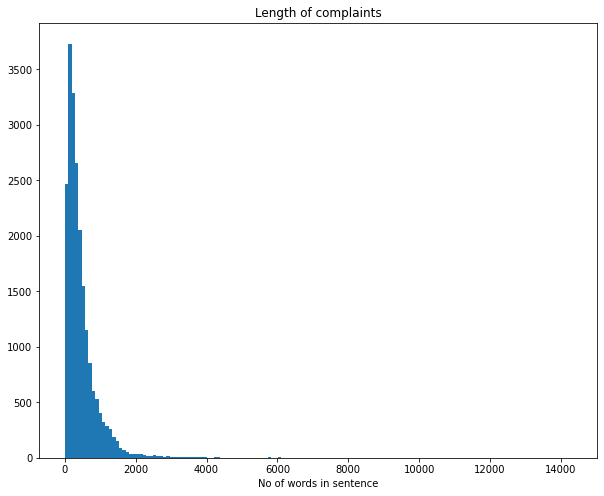

In [171]:
# Write your code here to visualise the data according to the 'Complaint' character length
complaint_len = [len(i) for i in df_clean['complaint_POS_removed']]
plt.figure(figsize=(10,8))
plt.hist(complaint_len,bins=150)
plt.xlabel('No of words in sentence')
plt.title('Length of complaints')
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [172]:
# Using a word cloud find the top 40 words by frequency among all the articles after processing the text
comment_words = ""
for words in df_clean['complaint_POS_removed'].tolist():
    comment_words += words

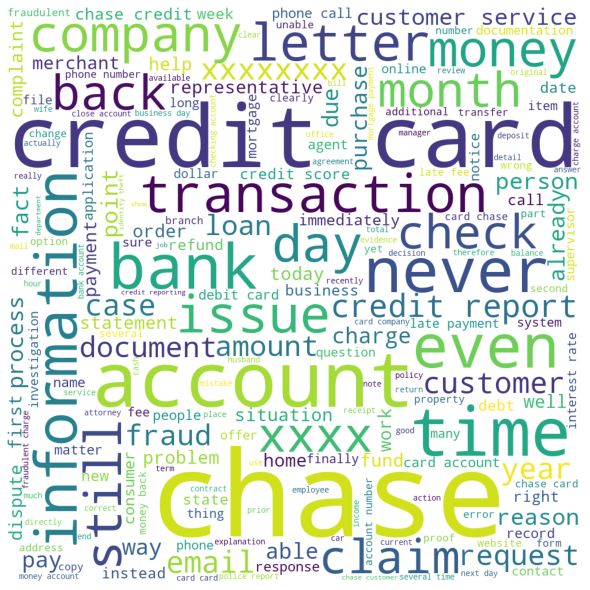

In [173]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def plotWordCloud(words):
    wordcloud = WordCloud(width = 1000, height = 1000,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(words)
    
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

#words = "Using a word cloud find the top 40 words by frequency among all the articles after processing the text"
plotWordCloud(comment_words)

In [174]:
df_clean['complaint_POS_removed'].head()

0    good morning name chase debt verification stat...
1    card agent anniversary date agent wrong inform...
2    card however fraudulent application identity c...
3    ticket offer ticket reward card information of...
4    son check account never money grand son clear ...
Name: complaint_POS_removed, dtype: object

In [175]:
# Removing -PRON- from the text corpus
df_clean['complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

# This version of spacy does not have the -PRON-. So the above step does not do anything.

In [176]:
df_clean['complaint_clean'].head()

0    good morning name chase debt verification stat...
1    card agent anniversary date agent wrong inform...
2    card however fraudulent application identity c...
3    ticket offer ticket reward card information of...
4    son check account never money grand son clear ...
Name: complaint_clean, dtype: object

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [177]:
# Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_unigrams(corpus,n=None):
    vec = CountVectorizer(ngram_range=(1,1),stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_of_words = bag_of_words.sum(axis=0)
    words_freq = [(word,sum_of_words[0,idx]) for word,idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq,key = lambda x:x[1],reverse=True)
    return words_freq[:n]

def plot_ngrams(top10):
    x = pd.DataFrame(top10,columns=['ngram','count'])
    plt.figure(figsize=(15,10))
    sns.barplot(x=x['ngram'],y=x['count'])

get_top_n_unigrams(df_clean['complaint_clean'],n=30)

[('account', 41436),
 ('chase', 35221),
 ('credit', 30348),
 ('card', 29673),
 ('payment', 20454),
 ('time', 15698),
 ('charge', 12156),
 ('money', 11590),
 ('day', 10628),
 ('check', 10098),
 ('information', 9305),
 ('bank', 9055),
 ('number', 8531),
 ('month', 8388),
 ('loan', 8320),
 ('customer', 8020),
 ('transaction', 7948),
 ('year', 7887),
 ('fee', 7767),
 ('mortgage', 7626),
 ('letter', 7584),
 ('balance', 7436),
 ('phone', 7331),
 ('report', 7026),
 ('company', 6798),
 ('claim', 6398),
 ('fraud', 6228),
 ('service', 6036),
 ('xxxx', 5755),
 ('email', 5719)]

account
chase
credit
card
payment
time
charge
money
day
check


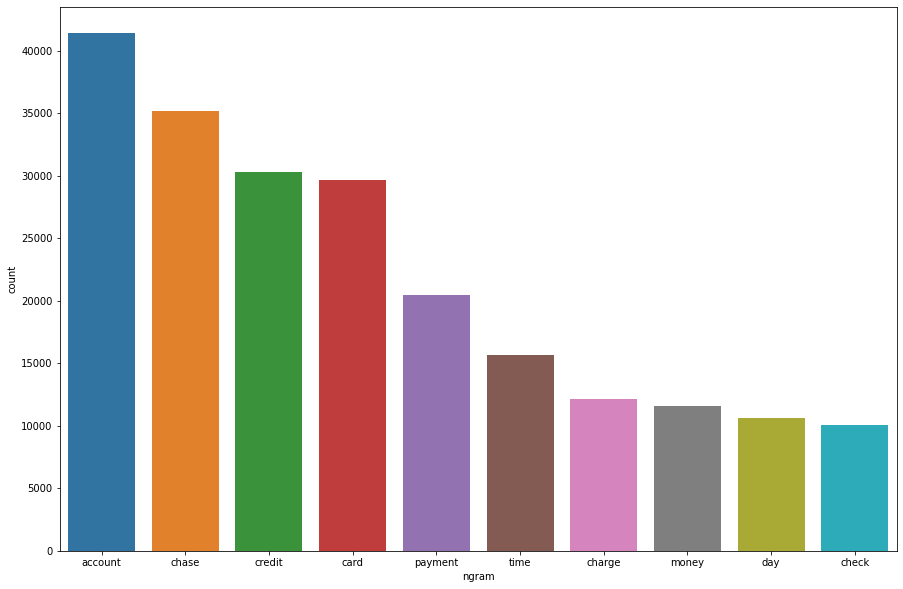

In [178]:
# Print the top 10 words in the unigram frequency
top_10_unigram = get_top_n_unigrams(df_clean['complaint_clean'], n=10)
for i in top_10_unigram:
    print(i[0])
plot_ngrams(top_10_unigram)

In [179]:
# Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2,2),stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_of_words = bag_of_words.sum(axis=0)
    #print('--1',sum_of_words)
    #for word,idx in vec.vocabulary_.items():
        #print(word)
        #print(idx)
        #break
    words_freq =[(word , sum_of_words[0,idx]) for word,idx in vec.vocabulary_.items() ]
    words_freq = sorted(words_freq,key=lambda x:x[1],reverse = True)
    return words_freq[:n]

get_top_n_bigrams(df_clean['complaint_clean'], n=30)

[('credit card', 12113),
 ('credit report', 3451),
 ('customer service', 2437),
 ('chase credit', 1877),
 ('account account', 1710),
 ('credit score', 1634),
 ('debit card', 1563),
 ('card account', 1534),
 ('late payment', 1452),
 ('account chase', 1397),
 ('chase account', 1351),
 ('phone number', 1238),
 ('money account', 1235),
 ('card chase', 1183),
 ('account number', 1176),
 ('chase card', 1138),
 ('card card', 1110),
 ('late fee', 1084),
 ('account credit', 1074),
 ('close account', 1046),
 ('card company', 1030),
 ('mortgage payment', 970),
 ('fraudulent charge', 944),
 ('charge account', 917),
 ('business day', 914),
 ('checking account', 913),
 ('payment payment', 889),
 ('card credit', 872),
 ('bank account', 870),
 ('police report', 869)]

credit card
credit report
customer service
chase credit
account account
credit score
debit card
card account
late payment
account chase


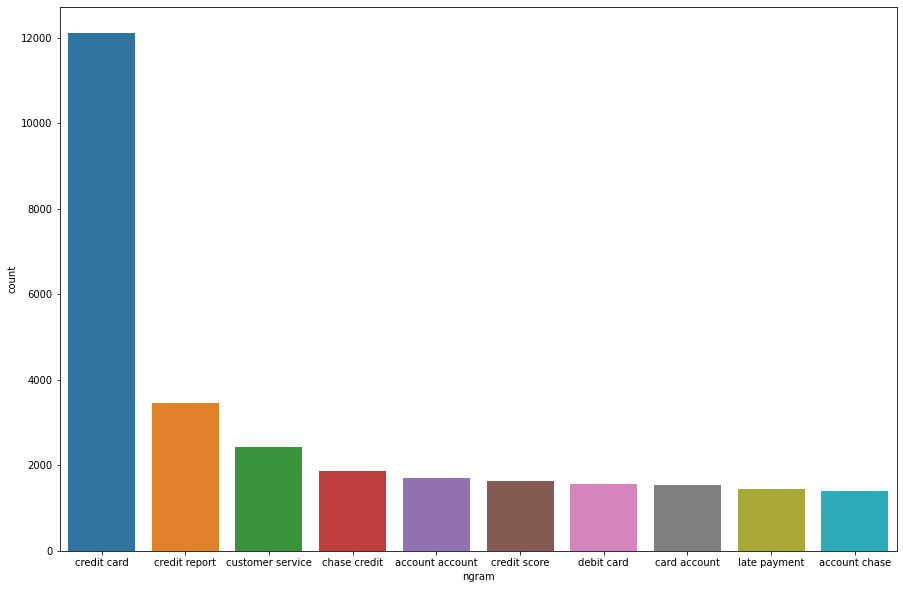

In [180]:
# Print the top 10 words in the bigram frequency
top_10_bigram = get_top_n_bigrams(df_clean['complaint_clean'], n=10)
for i in top_10_bigram:
    print(i[0])

plot_ngrams(top_10_bigram)

In [181]:
# Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_top_n_trigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3,3),stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_of_words = bag_of_words.sum(axis=0)
    #print('--1',sum_of_words)
    #for word,idx in vec.vocabulary_.items():
        #print(word)
        #print(idx)
        #break
    words_freq =[(word , sum_of_words[0,idx]) for word,idx in vec.vocabulary_.items() ]
    words_freq = sorted(words_freq,key=lambda x:x[1],reverse = True)
    return words_freq[:n]

get_top_n_trigrams(df_clean['complaint_clean'], n=30)

[('chase credit card', 1396),
 ('credit card account', 972),
 ('credit card company', 855),
 ('credit card chase', 608),
 ('credit card credit', 437),
 ('card credit card', 399),
 ('inquiry credit report', 374),
 ('account credit card', 346),
 ('charge credit card', 336),
 ('social security number', 292),
 ('chase customer service', 278),
 ('account credit report', 262),
 ('credit reporting agency', 261),
 ('credit card card', 260),
 ('hard inquiry credit', 255),
 ('credit card payment', 243),
 ('victim identity theft', 237),
 ('fair credit reporting', 228),
 ('customer service representative', 224),
 ('payment credit card', 214),
 ('credit card statement', 214),
 ('credit card balance', 214),
 ('credit reporting act', 211),
 ('late payment credit', 200),
 ('credit report credit', 195),
 ('credit card number', 185),
 ('new credit card', 184),
 ('credit card charge', 184),
 ('debt collection practice', 175),
 ('insufficient fund fee', 168)]

chase credit card
credit card account
credit card company
credit card chase
credit card credit
card credit card
inquiry credit report
account credit card
charge credit card
social security number


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

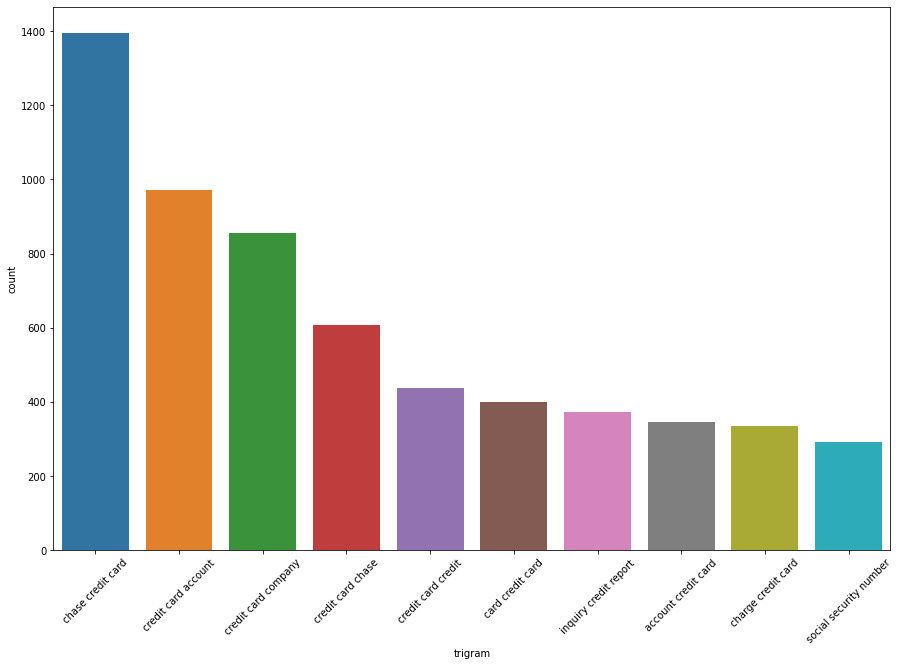

In [182]:
# Print the top 10 words in the trigram frequency
top_10_trigram = get_top_n_trigrams(df_clean['complaint_clean'], n=10)
for i in top_10_trigram:
    print(i[0])

x = pd.DataFrame(top_10_trigram,columns=['trigram','count'])
plt.figure(figsize=(15,10))
sns.barplot(x=x['trigram'],y=x['count'])
plt.xticks(rotation=45)

## Remove xxxx
The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [183]:
df_clean['complaint_clean'].head()

0    good morning name chase debt verification stat...
1    card agent anniversary date agent wrong inform...
2    card however fraudulent application identity c...
3    ticket offer ticket reward card information of...
4    son check account never money grand son clear ...
Name: complaint_clean, dtype: object

In [184]:
# Test the regex on a samplt string
sub_word = re.sub('xxxx[x]*', '', "abc xxxx def xxxxx ghi xxxxxxxxx jkl");print(sub_word)
sub_word.replace('  ',' ')

abc  def  ghi  jkl


'abc def ghi jkl'

In [185]:
df_clean['complaint_clean'] = df_clean['complaint_clean'].str.replace('xxxx[x]*', '', regex=True)
df_clean['complaint_clean'] = df_clean['complaint_clean'].str.replace('  ', ' ')

In [186]:
# Remove chase which is the top most word which is the name of the bank
df_clean['complaint_clean'] = df_clean['complaint_clean'].str.replace('chase', '')

In [187]:
#All masked texts has been removed
df_clean.head()

,complaint,complaint_lemma,complaint_POS_removed,complaint_clean
0,good morning my name is xxxx xxxx and i apprec...,"[good, morning, name, xxxx, xxxx, appreciate, ...",good morning name chase debt verification stat...,good morning name debt verification statement...
1,i upgraded my xxxx xxxx card in and was told ...,"[upgraded, xxxx, xxxx, card, told, agent, upgr...",card agent anniversary date agent wrong inform...,card agent anniversary date agent wrong inform...
2,chase card was reported on however fraudulent...,"[chase, card, reported, however, fraudulent, a...",card however fraudulent application identity c...,card however fraudulent application identity c...
3,on while trying to book a xxxx xxxx ticket ...,"[trying, book, xxxx, xxxx, ticket, came, acros...",ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
4,my grand son give me check for i deposit it i...,"[grand, son, give, check, deposit, chase, acco...",son check account never money grand son clear ...,son check account never money grand son clear ...


In [188]:
df_clean['complaint_clean'].head()

0    good morning name  debt verification statement...
1    card agent anniversary date agent wrong inform...
2    card however fraudulent application identity c...
3    ticket offer ticket reward card information of...
4    son check account never money grand son clear ...
Name: complaint_clean, dtype: object

In [189]:
comment_words = ""
for words in df_clean['complaint_clean'].tolist():
    comment_words += words

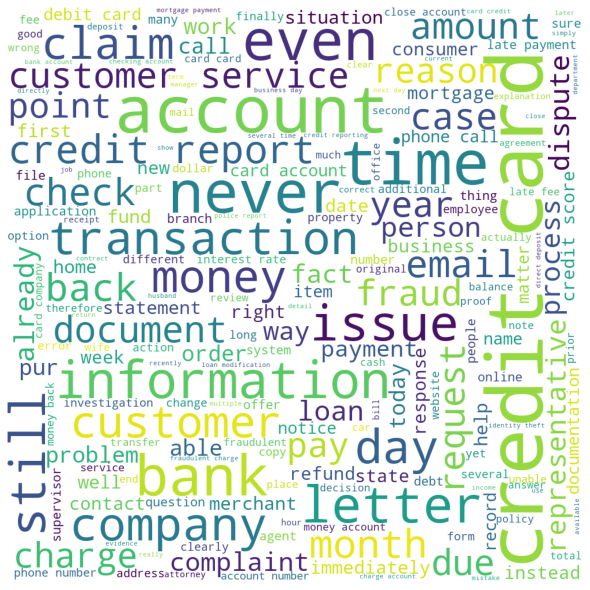

In [190]:
plotWordCloud(comment_words)

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [191]:
df_clean['complaint_clean'].head()

0    good morning name  debt verification statement...
1    card agent anniversary date agent wrong inform...
2    card however fraudulent application identity c...
3    ticket offer ticket reward card information of...
4    son check account never money grand son clear ...
Name: complaint_clean, dtype: object

In [192]:
# Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer()# max_df= 90 , min_df=10)

# Including the max_df and min_df parameters did not give a good result. Hence not including them

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [193]:
# Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['complaint_clean'].tolist())
print(dtm)  

  (0, 7202)	0.16038946859190814
  (0, 15788)	0.24109248134011244
  (0, 3240)	0.17456600245196474
  (0, 8005)	0.12475916932992498
  (0, 13769)	0.1674516773960172
  (0, 2782)	0.288008571037569
  (0, 9945)	0.1241089962884607
  (0, 9313)	0.17180928610399868
  (0, 8176)	0.18955126076796402
  (0, 17294)	0.3090641828322156
  (0, 1382)	0.12200997516544669
  (0, 84)	0.29776521985781723
  (0, 15048)	0.15477187981954468
  (0, 17378)	0.24962654214693655
  (0, 3929)	0.5363786831618333
  (0, 10135)	0.15507339407097484
  (0, 9984)	0.22788711475116274
  (0, 6849)	0.1710262488503759
  (1, 3168)	0.23345769207547953
  (1, 10905)	0.1619707092402405
  (1, 17947)	0.1783133278419998
  (1, 3848)	0.283970690372335
  (1, 733)	0.6747132352869225
  (1, 464)	0.5755353912905213
  (1, 2151)	0.08523890902868968
  :	:
  (21071, 8186)	0.15685907810405542
  (21071, 11832)	0.18416324262352834
  (21071, 12345)	0.12808633619937504
  (21071, 4838)	0.1344800418867962
  (21071, 488)	0.1302813563175871
  (21071, 14463)	0.14509

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [194]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [195]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

In [196]:
# Document - Topic
W = nmf_model.fit_transform(dtm)
len(tfidf.get_feature_names()), type(W), W.shape, W[:10]

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



(18047,
 numpy.ndarray,
 (21072, 5),
 array([[0.0075242 , 0.01142589, 0.00418221, 0.00415463, 0.03049206],
        [0.        , 0.01157645, 0.00262045, 0.01461927, 0.00645751],
        [0.        , 0.04799717, 0.        , 0.01437325, 0.        ],
        [0.01478838, 0.05497041, 0.        , 0.00701204, 0.01617975],
        [0.050072  , 0.        , 0.        , 0.00564241, 0.00430648],
        [0.        , 0.04214209, 0.        , 0.        , 0.        ],
        [0.05393084, 0.0001766 , 0.01927128, 0.00229967, 0.00870356],
        [0.00468582, 0.00285312, 0.05368516, 0.00675308, 0.03648668],
        [0.01898042, 0.        , 0.00244118, 0.06857653, 0.01766124],
        [0.        , 0.10399827, 0.        , 0.        , 0.        ]]))

In [197]:
# Topic - Words
H = nmf_model.components_
type(H), H.shape, H[:10]

(numpy.ndarray,
 (5, 18047),
 array([[0.00000000e+00, 7.80744422e-04, 9.19201108e-04, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 2.70756387e-05, 0.00000000e+00, ...,
         8.57752552e-04, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.44973361e-05, 0.00000000e+00, ...,
         0.00000000e+00, 3.16236412e-03, 0.00000000e+00],
        [1.29641125e-04, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 1.17368149e-03, 1.80424203e-04],
        [9.45989850e-04, 0.00000000e+00, 0.00000000e+00, ...,
         2.25722861e-03, 3.40663316e-03, 5.17032538e-05]]))

In [198]:
#Print the Top15 words for each of the topics
TOP_WORDS = 15
words = np.array(tfidf.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, TOP_WORDS)), index=[f'Topic {i}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(TOP_WORDS)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:TOP_WORDS]
    topic_words.iloc[i] = words[ix]

topic_words.to_csv("out.csv")
topic_words

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 0,account,check,money,fund,bank,deposit,branch,day,number,back,business,transfer,customer,open,time
Topic 1,credit,card,report,inquiry,account,score,hard,company,application,limit,never,debt,information,balance,year
Topic 2,payment,late,balance,fee,due,interest,month,statement,monthly,amount,pay,date,day,time,full
Topic 3,charge,card,transaction,dispute,merchant,claim,fraud,fraudulent,pur,email,refund,service,time,fee,call
Topic 4,loan,mortgage,modification,home,property,year,rate,time,document,letter,sale,foreclosure,debt,information,process


In [199]:
# Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_mapping = {
    'Topic 0': 'Bank account services',
    'Topic 1': 'Credit card / Prepaid card',
    'Topic 2': 'Others',  
    'Topic 3': 'Theft/Dispute reporting',
    'Topic 4': 'Mortgages/loans', 
}

In [200]:
#Assign the best topic to each of the complaints in Topic Column

#df_clean['Topic'] = #write your code to assign topics to each rows.
df_W = pd.DataFrame(W, columns=[f'Topic {i}' for i in range(num_topics)])
df_clean['Topic'] = df_W.apply(lambda x: topic_mapping.get(x.idxmax()), axis=1)
df_clean['Topic']

0                   Mortgages/loans
1           Theft/Dispute reporting
2        Credit card / Prepaid card
3        Credit card / Prepaid card
4             Bank account services
                    ...            
21067    Credit card / Prepaid card
21068       Theft/Dispute reporting
21069       Theft/Dispute reporting
21070                        Others
21071                        Others
Name: Topic, Length: 21072, dtype: object

In [201]:
df_clean.head()

,complaint,complaint_lemma,complaint_POS_removed,complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,"[good, morning, name, xxxx, xxxx, appreciate, ...",good morning name chase debt verification stat...,good morning name debt verification statement...,Mortgages/loans
1,i upgraded my xxxx xxxx card in and was told ...,"[upgraded, xxxx, xxxx, card, told, agent, upgr...",card agent anniversary date agent wrong inform...,card agent anniversary date agent wrong inform...,Theft/Dispute reporting
2,chase card was reported on however fraudulent...,"[chase, card, reported, however, fraudulent, a...",card however fraudulent application identity c...,card however fraudulent application identity c...,Credit card / Prepaid card
3,on while trying to book a xxxx xxxx ticket ...,"[trying, book, xxxx, xxxx, ticket, came, acros...",ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,Credit card / Prepaid card
4,my grand son give me check for i deposit it i...,"[grand, son, give, check, deposit, chase, acco...",son check account never money grand son clear ...,son check account never money grand son clear ...,Bank account services


In [202]:
df_clean.shape

(21072, 5)

In [203]:
#Print the first 5 Complaint for each of the Topics
df_clean_gp = df_clean.groupby('Topic').head(10)
df_clean_gp[['complaint_clean','Topic']].sort_values('Topic')

def showSampleComplaintsOfTopic(topic):
    print("Topic", topic)
    [print(complaint, "\n") for complaint in df_clean_gp[df_clean_gp['Topic']==topic]['complaint_clean'].values[0:10]]

In [204]:
showSampleComplaintsOfTopic('Bank account services')

Topic Bank account services
son check account never money grand son clear money pay son time call verify check owner country time date check number claim number 

card branch customer service representative account actually branch fund currently direct deposit place employment bank associate customer service representative fund additional business day branch yet actually account fund long present current statement business day date available bank teller  check fund left account currently unfortunately additional financial bind fee late rent late car payment short notice thing actually peace mind fact  situation grossly even bank teller inform account suspicious suspicious look reserve right close account time notice form document notice thing actually peace mind fact  situation grossly even bank teller inform account suspicious suspicious look reserve right close account time notice form document situation truly livelihood deal professionally 

 

bonus account direct deposit bonus day

In [205]:
showSampleComplaintsOfTopic('Credit card / Prepaid card')

Topic Credit card / Prepaid card
card however fraudulent application identity consent fraudulently service credit identity applicant 

ticket offer ticket reward card information offer screen decision immediately immediately notification screen representative application information offer even credit offer first account statement pur ticket explicitly absolutely longer interested account application representative later application explicit request proceed application contrary representative fact ahead open credit account name credit report  correct information credit report even ahead process application consent error 

inquiry 

credit card incorrectly datum credit report company issue 

several time fraudulent inquiry need call contact original creditor inquiry report several attempt able right person care issue matter many attempt fraudulent credit report legal action never kind iquiry matter 

senior citizen several company time share company misleading refund credit card unsuccef

In [206]:
showSampleComplaintsOfTopic('Mortgages/loans')

Topic Mortgages/loans
good morning name  debt verification statement acceptable bank validate debt instead mail month collect debt right information consumer thank help 

loan modification  mo behind payment aen always 

branch exact reinstatement amount order wrongful foreclosure residential property however even rule regulation total payoff order wrongful foreclosure proceeding sale date family resident know short time minimum reinstatement amount avoid foreclosure chapter bankruptcy filing appreciate assistant quality sen family fraudulent default claim previous complaint previous complaint product mortgage issue wrongful foreclosure 

never title  several time resolution time release state registration state title rent car use car 

day due current numerous time loan modification loss mitigation assistance help loan forbearance option issue dti high excessive debt time credit score low 

military member auto finance refusing pay gap insurancewaiver coverage time financing agreement

In [207]:
showSampleComplaintsOfTopic('Others')

Topic Others
summer month experience decline income due employment therefore month payment company  almost year request payment extension never delinquent auto loan payment however month payment extension year situation representative supervisor avail lengthy discussion reason contractual reason denial therefore office  followup week later role help matter representative conference call handing request information request still policy change explanation representative letter explanation letter reason policy change cfpb help denial payment extension especially clear reason denial 

pur payment closing date statement statement outstanding pur balance previous month statement show pur prior however statement still balance promotional balance promotional balance difference apparently minimum payment  thought pur promotional balance first minimum payment payment excess minimum high interest rate balance first first time  financial law large profit help problem logic deaf ear  advance assist

In [208]:
showSampleComplaintsOfTopic('Theft/Dispute reporting')

Topic Theft/Dispute reporting
card agent anniversary date agent wrong information order anniversary date  consent agent 

payment online retailer  quick pay scam website confirmation product response inquiry order  information transaction refund retailer bank  secured message way transaction contact information message response original email informing transfer however website scam inquiry email team order well regard refund request consumer online technical support team number email situation claim department call information initiating transfer agent end quickly possible interrupt closing script contact number opportunity information right question word phrase use information system initially transaction customer service agent information transaction system bank app transaction line well understanding situation call second time agent information receiving bank additional information information situation contact information already finally due nature transaction type transaction  inf

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [209]:
# Create the dictionary of Topic names and Topics
Topic_names = { 'Bank account services'         : 'Bank Account services',
                'Credit card / Prepaid card'    : 'Credit card or prepaid card',
                'Theft/Dispute reporting'       : 'Theft/Dispute Reporting',
                'Mortgages/loans'               : 'Mortgage/Loan',
                'Others'                        : 'Others' }

Topic_names_inv = {     1 : 'Bank Account services',
                        2 : 'Credit card or prepaid card',
                        3 : 'Theft/Dispute Reporting', 
                        4 : 'Mortgage/Loan',
                        5 : 'Others' }
                        
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [210]:
df_clean[['complaint_clean', 'Topic']].head(10)

,complaint_clean,Topic
0,good morning name debt verification statement...,Mortgage/Loan
1,card agent anniversary date agent wrong inform...,Theft/Dispute Reporting
2,card however fraudulent application identity c...,Credit card or prepaid card
3,ticket offer ticket reward card information of...,Credit card or prepaid card
4,son check account never money grand son clear ...,Bank Account services
5,inquiry,Credit card or prepaid card
6,card branch customer service representative ac...,Bank Account services
7,summer month experience decline income due emp...,Others
8,payment online retailer quick pay scam websit...,Theft/Dispute Reporting
9,credit card incorrectly datum credit report co...,Credit card or prepaid card


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [211]:
#Create the dictionary again of Topic names and Topics

Topic_names = { 'Bank Account services'         : 1,
                'Credit card or prepaid card'   : 2,
                'Theft/Dispute Reporting'       : 3,
                'Mortgage/Loan'                 : 4,
                'Others'                        : 5 }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [212]:
df_clean[['complaint_clean', 'Topic']].head(10)

,complaint_clean,Topic
0,good morning name debt verification statement...,4
1,card agent anniversary date agent wrong inform...,3
2,card however fraudulent application identity c...,2
3,ticket offer ticket reward card information of...,2
4,son check account never money grand son clear ...,1
5,inquiry,2
6,card branch customer service representative ac...,1
7,summer month experience decline income due emp...,5
8,payment online retailer quick pay scam websit...,3
9,credit card incorrectly datum credit report co...,2


In [213]:
df_clean.Topic.isnull().sum()

0

In [214]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
from sklearn.model_selection import train_test_split
X = df_clean['complaint_clean']
y = df_clean['Topic']
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,test_size=0.3,random_state=100)
X.shape, X_train.shape, X_test.shape
#training_data=

((21072,), (14750,), (6322,))

In [215]:
X_train.head()

8215     husband periodic charge behalf automatically c...
6040     check account check home equity teller check a...
4016     respectfully card service service never  sapph...
15773    charge electronically day prior actual stay ap...
13593                               extended overdraft fee
Name: complaint_clean, dtype: object

#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vector to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [216]:
#Write your code to get the Vector count
vec = CountVectorizer(ngram_range=(1,1)).fit(X_train)
bag_of_words = vec.transform(X_train)
print(bag_of_words.shape)
sum_of_words = bag_of_words.sum(axis=0)
words_freq = [(word,sum_of_words[0,idx]) for word,idx in vec.vocabulary_.items()]
words_freq = sorted(words_freq,key = lambda x:x[1],reverse=True)
print(words_freq[:10])

(14750, 15089)
[('account', 28671), ('credit', 21104), ('card', 20354), ('payment', 14331), ('time', 11134), ('charge', 8575), ('money', 8103), ('day', 7432), ('check', 7078), ('never', 6931)]


In [217]:
#Write your code here to transform the word vector to tf-idf
tfidf = TfidfVectorizer().fit(X_train)
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
print(f"X_train_tfidf.shape {X_train_tfidf.shape}, X_test_tfidf.shape {X_test_tfidf.shape}\n"\
        f"tfidf.vocabulary {len(list(tfidf.vocabulary_))}, {list(tfidf.vocabulary_)[0:10]}")

terms = tfidf.get_feature_names()
print(len(terms), terms[0:10])

X_train_tfidf.shape (14750, 15089), X_test_tfidf.shape (6322, 15089)
tfidf.vocabulary 15089, ['husband', 'periodic', 'charge', 'behalf', 'automatically', 'credit', 'card', 'information', 'file', 'extra']
15089 ['aaarating', 'aaccount', 'aacount', 'aarp', 'aaving', 'ab', 'aback', 'abandonment', 'abatement', 'aberrant']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [218]:
cv_vocab = [word for word, freq in words_freq]; print(len(cv_vocab), cv_vocab[0:10])
tfidf_vocab = list(tfidf.vocabulary_); print(len(tfidf_vocab),tfidf_vocab[0:10])
diff = set(cv_vocab)-set(tfidf_vocab);len(diff);list(diff)[0:10]

15089 ['account', 'credit', 'card', 'payment', 'time', 'charge', 'money', 'day', 'check', 'never']
15089 ['husband', 'periodic', 'charge', 'behalf', 'automatically', 'credit', 'card', 'information', 'file', 'extra']


[]

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

#### Utility functions

In [219]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score

def evaluate_model(dt_classifier, category, X, y):
    print(f"{category} Accuracy : {percent(accuracy_score(y, dt_classifier.predict(X)), 1)}%")
    print(f"{category} Confusion Matrix:")
    print(confusion_matrix(y, dt_classifier.predict(X)))

### Logistic Regression

In [220]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

import statsmodels.api as sm

In [221]:
model = LogisticRegression(max_iter=1000, random_state=40)
logreg = model.fit(X_train_tfidf,y_train)

In [222]:
logreg.predict_proba(X_test_tfidf)

array([[8.24589612e-01, 1.23528855e-01, 1.89463047e-02, 9.12989379e-03,
        2.38053345e-02],
       [1.86417632e-01, 3.42847849e-02, 4.98709256e-01, 2.56527710e-01,
        2.40606177e-02],
       [9.43718321e-01, 4.71919497e-03, 4.59670164e-02, 2.02381339e-03,
        3.57165451e-03],
       ...,
       [9.39184723e-01, 1.40177743e-02, 9.61542624e-03, 2.60310134e-02,
        1.11510634e-02],
       [6.83362886e-03, 8.09297840e-03, 9.53668150e-01, 2.84602610e-02,
        2.94498192e-03],
       [2.59768770e-05, 1.40855625e-05, 2.15027694e-05, 9.99915042e-01,
        2.33929273e-05]])

In [223]:
y_pred = logreg.predict(X_test_tfidf)

In [224]:
y_pred

array([1, 3, 1, ..., 1, 3, 4])

In [225]:
y_test

53       1
4269     3
13741    1
20341    1
13105    4
        ..
1439     3
20979    2
7383     1
621      3
20581    4
Name: Topic, Length: 6322, dtype: int64

In [226]:
#evaluate_model(dt_classifier, category, X, y)
evaluate_model(logreg, "TRAIN", X_train_tfidf, y_train);print()
evaluate_model(logreg, "TEST", X_test_tfidf, y_test);print()
print(classification_report(y_test,y_pred))

TRAIN Accuracy : 98.98%
TRAIN Confusion Matrix:
[[3395    3    3   24    2]
 [   0 3354    9    4    1]
 [  12   18 3366    7    5]
 [  15    5    8 2637    1]
 [   7    3   12   12 1847]]

TEST Accuracy : 95.78%
TEST Confusion Matrix:
[[1416   11   12   17    0]
 [   7 1425   22    7    0]
 [  29   12 1392   12   11]
 [  21   18   14 1100    6]
 [  17   18   15   18  722]]

              precision    recall  f1-score   support

           1       0.95      0.97      0.96      1456
           2       0.96      0.98      0.97      1461
           3       0.96      0.96      0.96      1456
           4       0.95      0.95      0.95      1159
           5       0.98      0.91      0.94       790

    accuracy                           0.96      6322
   macro avg       0.96      0.95      0.96      6322
weighted avg       0.96      0.96      0.96      6322



The train and test accuracy is quite good. But let's build decision tree and random forest models and see if they perform better

### Decision Tree

In [249]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [250]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [2, 3, 4], #  5, 10] If 5 and 10 are included, the best estimator has depth of 10 and the interpretation of the model was difficult. So using only the values of 2,3 4
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=params, 
                           cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [251]:
%%time
grid_search.fit(X_train_tfidf, y_train)

Fitting 4 folds for each of 30 candidates, totalling 120 fits
CPU times: user 1.87 s, sys: 201 ms, total: 2.07 s
Wall time: 39.7 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)

In [252]:
df_score = pd.DataFrame(grid_search.cv_results_)
df_score.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.365321,0.023912,0.003307,0.000261,gini,2,5,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.515184,0.50705,0.509357,0.5099,0.510373,0.002977,21
1,0.341680,0.008718,0.003237,0.000139,gini,2,10,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.515184,0.50705,0.509357,0.5099,0.510373,0.002977,21
2,0.330937,0.005710,0.003238,0.000312,gini,2,20,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.515184,0.50705,0.509357,0.5099,0.510373,0.002977,21
3,0.335012,0.012263,0.003196,0.000108,gini,2,50,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.515184,0.50705,0.509357,0.5099,0.510373,0.002977,21
4,0.318465,0.013349,0.003096,0.000054,gini,2,100,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.515184,0.50705,0.509357,0.5099,0.510373,0.002977,21


In [253]:
dt_best = grid_search.best_estimator_
dt_best

DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=100,
                       random_state=42)

In [254]:
evaluate_model(dt_best, "TRAIN", X_train_tfidf, y_train);print()
evaluate_model(dt_best, "TEST", X_test_tfidf, y_test);print()
print(classification_report(y_test, dt_best.predict(X_test_tfidf)))

TRAIN Accuracy : 70.36%
TRAIN Confusion Matrix:
[[2237  218  844   18  110]
 [ 143 2681  453    4   87]
 [ 237  232 2830   23   86]
 [ 151  216  969 1229  101]
 [  48   77  228  127 1401]]

TEST Accuracy : 68.84%
TEST Confusion Matrix:
[[ 914  103  366   12   61]
 [  64 1144  214    2   37]
 [ 111  110 1181    8   46]
 [  63   96  418  527   55]
 [  22   37   96   49  586]]

              precision    recall  f1-score   support

           1       0.78      0.63      0.70      1456
           2       0.77      0.78      0.78      1461
           3       0.52      0.81      0.63      1456
           4       0.88      0.45      0.60      1159
           5       0.75      0.74      0.74       790

    accuracy                           0.69      6322
   macro avg       0.74      0.68      0.69      6322
weighted avg       0.73      0.69      0.69      6322



The train and test accuracy of the decision tree is not very good. Let us try random forest

In [255]:
df_fi = pd.DataFrame({"variables": terms, "feature importance": dt_best.feature_importances_})
df_fi.sort_values(by='feature importance', ascending=False).head()

,variables,feature importance
2984,credit,0.329275
9431,payment,0.282417
103,account,0.152209
1981,charge,0.115423
7551,loan,0.098071


In [256]:
df_clean['Topic'] = df_clean['Topic'].apply(lambda x: str(x))
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21072 entries, 0 to 21071
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   complaint              21072 non-null  object
 1   complaint_lemma        21072 non-null  object
 2   complaint_POS_removed  21072 non-null  object
 3   complaint_clean        21072 non-null  object
 4   Topic                  21072 non-null  object
dtypes: object(5)
memory usage: 823.2+ KB


In [257]:
# Importing required packages for visualization
from IPython.display import Image  
from six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus, graphviz

from graphviz import Source
def get_dt_graph(dt_classifier, features):
    dot_data = StringIO()
    export_graphviz(dt_classifier, out_file=dot_data, filled=True,rounded=True, feature_names=features, class_names=["1", "2", "3", "4", "5"])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    graph.set_size('"15,25!"')
    return graph.create_png()

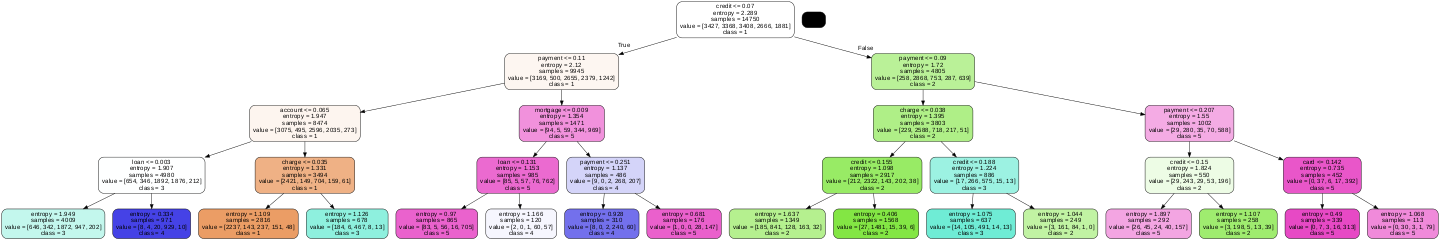

In [258]:
Image(get_dt_graph(dt_best, terms))

### Random Forest

In [259]:
from sklearn.ensemble import RandomForestClassifier
#rf = RandomForestClassifier(random_state=42, n_estimators=10, max_depth=3,oob_score=True)
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [4, 5, 10],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'max_features': [4, 8, 12],
    'n_estimators': [10, 30, 50, 100, 200]
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42, oob_score=True), param_grid=params, 
                          cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

In [260]:
%%time
grid_search.fit(X_train_tfidf,y_train)

Fitting 4 folds for each of 225 candidates, totalling 900 fits
CPU times: user 11.4 s, sys: 702 ms, total: 12.1 s
Wall time: 6min 49s


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(oob_score=True, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [4, 5, 10], 'max_features': [4, 8, 12],
                         'min_samples_leaf': [5, 10, 20, 50, 100],
                         'n_estimators': [10, 30, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [261]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(max_depth=10, max_features=12, min_samples_leaf=5,
                       n_estimators=200, oob_score=True, random_state=42)

In [262]:
evaluate_model(rf_best, "TRAIN", X_train_tfidf, y_train);print()
evaluate_model(rf_best, "TEST", X_test_tfidf, y_test);print()
print(classification_report(y_test, rf_best.predict(X_test_tfidf)))

TRAIN Accuracy : 56.87%
TRAIN Confusion Matrix:
[[2918  348  161    0    0]
 [ 331 2649  388    0    0]
 [ 548  428 2432    0    0]
 [ 626  962  689  389    0]
 [ 502  882  487   10    0]]

TEST Accuracy : 55.54%
TEST Confusion Matrix:
[[1238  141   77    0    0]
 [ 165 1117  179    0    0]
 [ 268  177 1011    0    0]
 [ 292  472  250  145    0]
 [ 224  347  211    8    0]]

              precision    recall  f1-score   support

           1       0.57      0.85      0.68      1456
           2       0.50      0.76      0.60      1461
           3       0.59      0.69      0.64      1456
           4       0.95      0.13      0.22      1159
           5       0.00      0.00      0.00       790

    accuracy                           0.56      6322
   macro avg       0.52      0.49      0.43      6322
weighted avg       0.55      0.56      0.48      6322



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



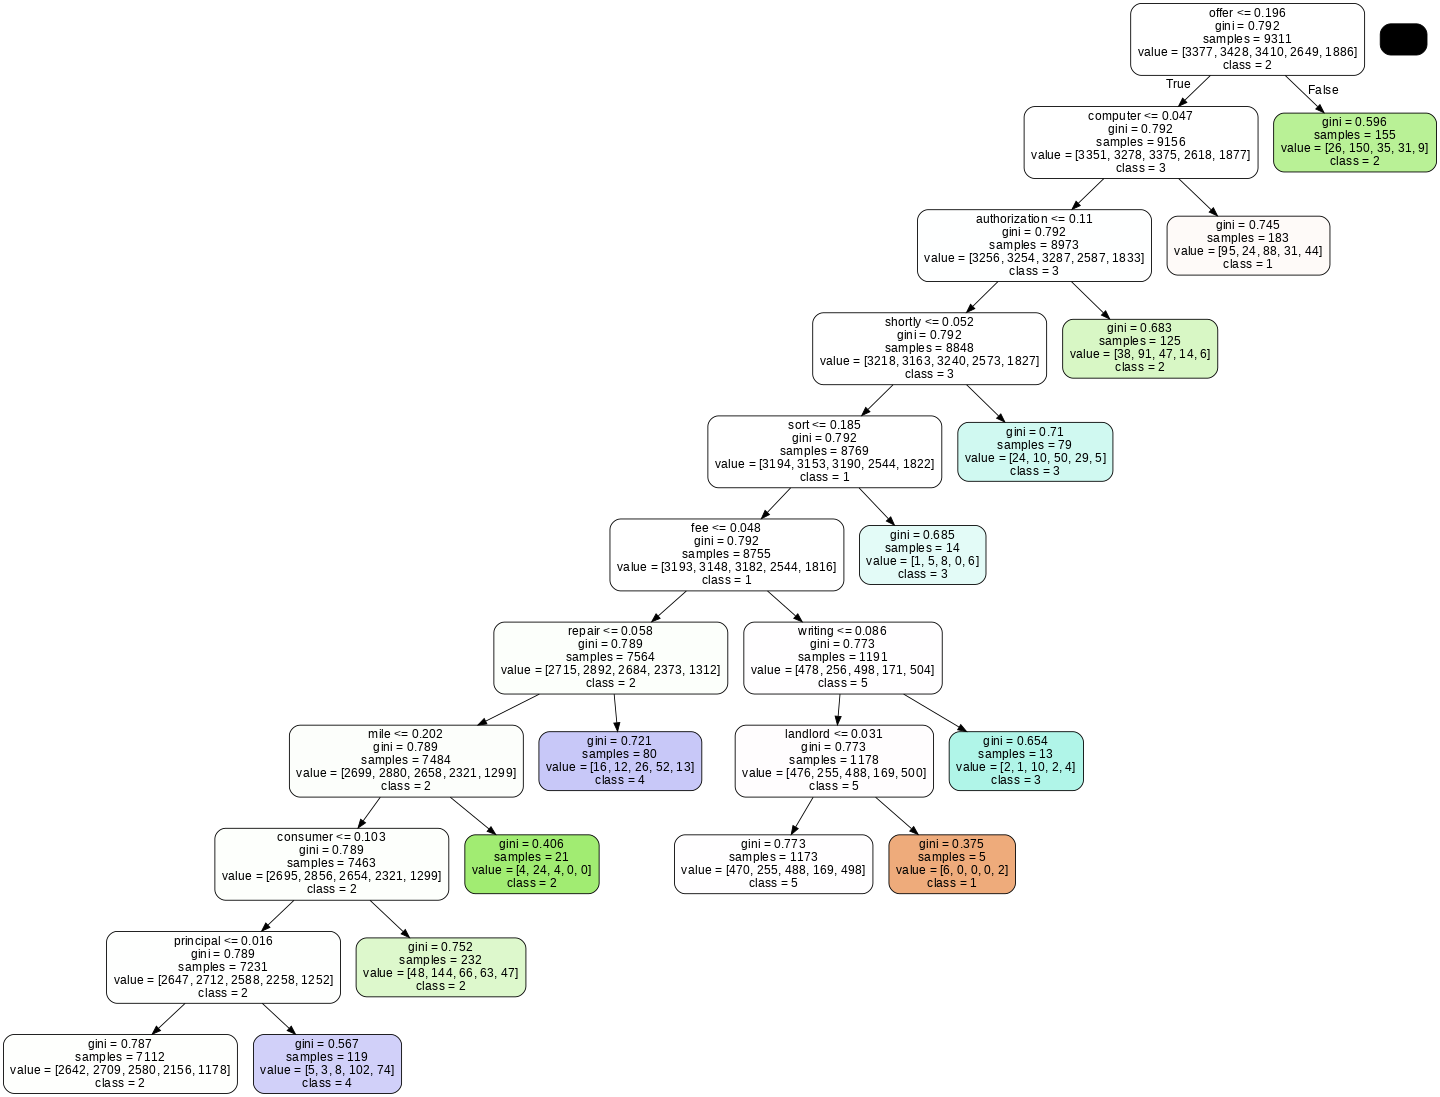

In [263]:
Image(get_dt_graph(rf_best.estimators_[0],terms), height=600, width=600)

The train and test accuracy of the random forest is the worst of the 3. So we will not consider this.

In [264]:
rf_best.oob_score_*100

51.14576271186441

### Summary

| Classifier | TRAIN Accuracy | TEST Accuracy |
|---|---|---|
| LogisticRegression |98.97% | 95.79%|
| DecisionTreeClassifier(max_depth=4, min_samples_leaf=50) | 70.36% | 68.84% |
| RandomForestClassifier(max_depth=10, max_features=12, min_samples_leaf=5,n_estimators=30, oob_score=True, random_state=42) |  56.87% | 55.54% |

Of the 3 models built, Logistic Regression has the best train and test accuracy, so let's use Logistic Regression model for prediction

In [265]:
y_pred = logreg.predict(X_test_tfidf)

In [266]:
X_test.shape, X_test_tfidf.shape, y_pred.shape

((6322,), (6322, 15089), (6322,))

In [267]:
y_pred[0:15]

array([1, 3, 1, 1, 4, 3, 5, 3, 1, 1, 3, 3, 2, 5, 2])

In [268]:
type(X_test)

pandas.core.series.Series

In [269]:
def showPrediction(index):
  print("TOPIC:", y_pred[index], Topic_names_inv[y_pred[index]], "\nTICKET COMMENT:", X_test.values[index], "\n")

Let's check a few samples and how these have been classified

In [270]:
for i in [0, 12, 1, 4, 6]:
  showPrediction(i)

TOPIC: 1 Bank Account services 
TICKET COMMENT: longer able access  credit card problem  account access however paperless way still due account way due still account  branch month point rest life paper statement access online online access internet 

TOPIC: 2 Credit card or prepaid card 
TICKET COMMENT: dear credit fraud personally still fortunately attempt show credit entire life good credit report constantly attempt 

TOPIC: 3 Theft/Dispute Reporting 
TICKET COMMENT: chass complaint number 

TOPIC: 4 Mortgage/Loan 
TICKET COMMENT: year ago foreclosure property mortgage also mortgage company document still attorney help different phase time help house livable apart still situation direction deed name court judge favour property pay rent second year house name work even roof hurricane advice address mortgage vacant lot house perimeter word pay light bill water vacant lot property year ago point property cut grass soon call attorney area question signature family member court proceeding

From the above samples, the classification seems to be working fine.